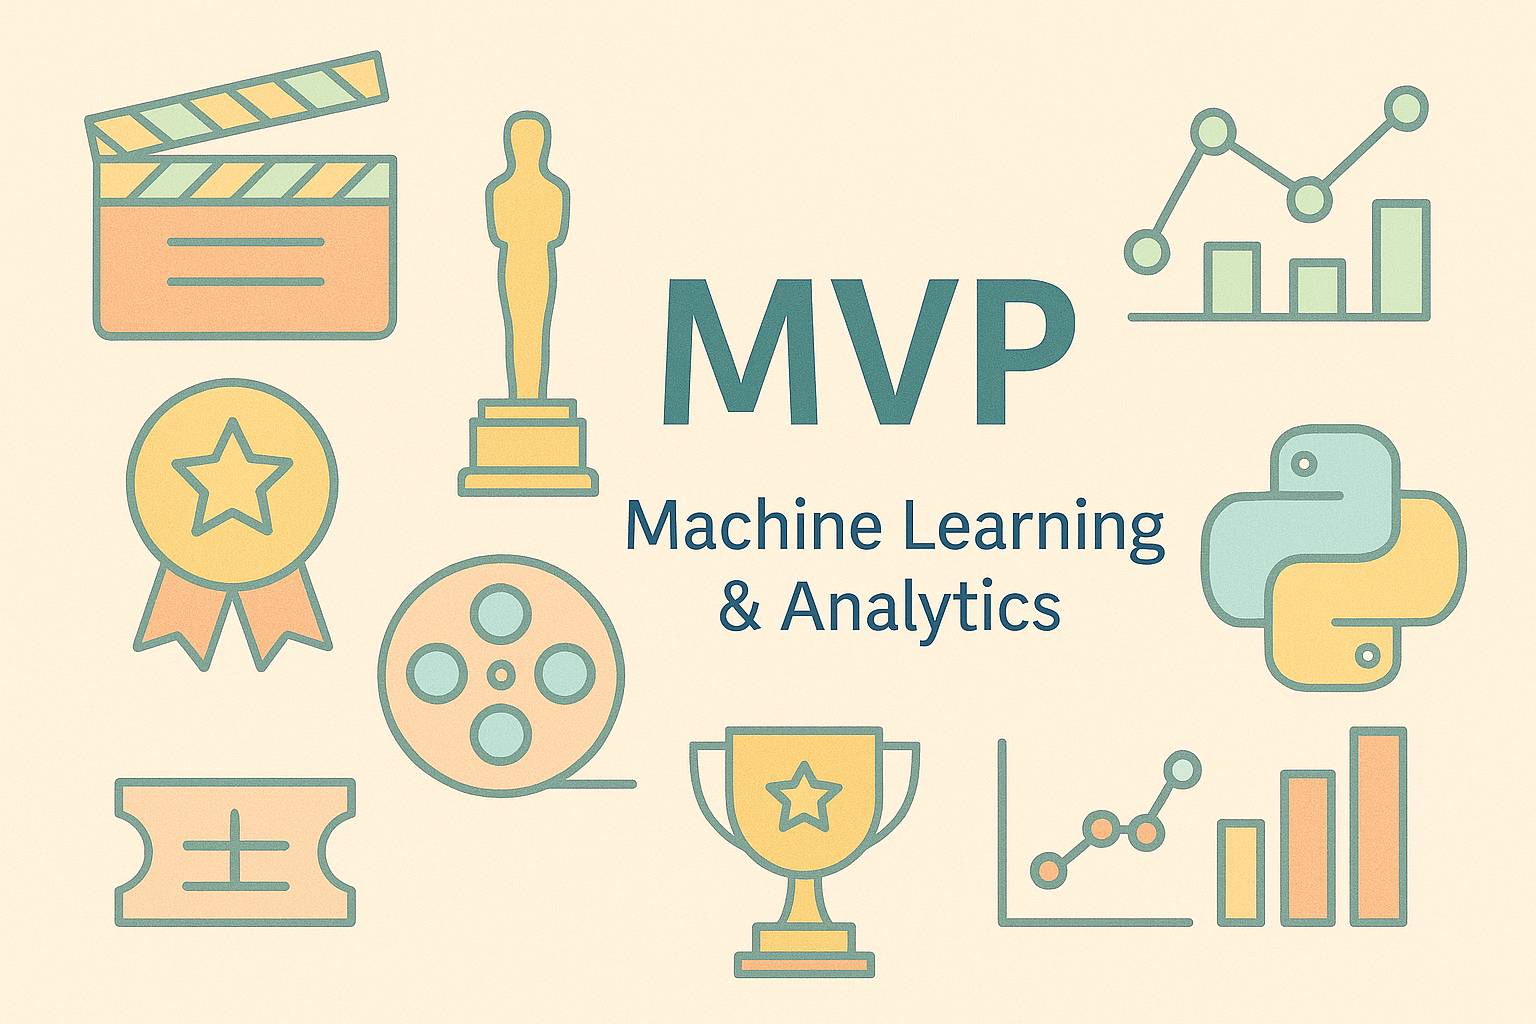

*imagem criada no chatGPT*


# MVP: *Machine Learning & Analytics*
**Autora:** Paula Alcantara Cardoso  

**Data:** 27/09/2025

**Matrícula:** 4052025000118

**Datasets:**
1. Informações dos indicados e vencedores do Oscar: https://www.kaggle.com/datasets/unanimad/the-oscar-award?resource=download
2. Informações de bilheteria: https://www.kaggle.com/datasets/raedaddala/top-500-600-movies-of-each-year-from-1960-to-2024
(ps: os dados foram baixados do seguinte github: https://github.com/RaedAddala/Scraping-IMDB/blob/master/Dataset/cleaned_data_from_1920_to_2025.csv, pois trata-se de um dataset já tratado reunindo filmes de 1920-2025)

---


### 1. Escopo, objetivo e definição do problema

**Contexto do problema e objetivo**  
O trabalho busca analisar dados históricos de indicações e vencedores do **Oscar (Academy Awards)** e propor um modelo preditivo capaz de identificar quais filmes têm maior probabilidade de vencer a categoria escolhida. O objetivo é aplicar técnicas de aprendizado de máquina para extrair padrões nos dados e avaliar se os modelos conseguem antecipar os resultados a partir de atributos relacionados aos filmes indicados.  

**Tipo de tarefa**  
- Classificação: cada indicado recebe o rótulo **1** (vencedor) ou **0** (não vencedor/indicado).  

**Área de aplicação**  
- Dados tabulares, combinando informações numéricas, categóricas e textuais sobre filmes, elenco, bilheteria, ano de lançamento, entre outros atributos.  

**Valor para o negócio/usuário**  
- Gerar insights sobre fatores associados ao sucesso em premiações.  
- Servir como **caso prático em aprendizado de máquina aplicado a um dataset desbalanceado**, com potencial de generalização para outros contextos de previsão em que apenas um entre vários candidatos pode ser escolhido (ex.: seleção de projetos, concursos, editais).  



## 2. Reprodutibilidade e ambiente


In [1]:
# === Setup básico e reprodutibilidade ===
import os, random, time, sys, math, ast, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, make_scorer)

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from scipy.stats import randint, loguniform, uniform

from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.ensemble import VotingClassifier

import platform, psutil

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Para frameworks que suportam seed adicional (ex.: PyTorch/TensorFlow), documente aqui:
# import torch; torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
# import tensorflow as tf; tf.random.set_seed(SEED)

print("Python:", sys.version.split()[0])
print("Seed global:", SEED)
print(f"CPU: {platform.processor()}")
print(f"Núcleos: {psutil.cpu_count(logical=True)}")
print(f"Memória RAM total: {round(psutil.virtual_memory().total / 1e9, 2)} GB")

Python: 3.12.11
Seed global: 42
CPU: x86_64
Núcleos: 2
Memória RAM total: 13.61 GB



### 2.1 Dependências (opcional)


In [2]:

# Exemplo: descomente o que precisar
# !pip install -q scikit-learn imbalanced-learn xgboost lightgbm catboost optuna
# !pip install -q pandas-profiling ydata-profiling
# !pip install -q matplotlib seaborn plotly
# !pip install -q statsmodels pmdarima

!pip install rapidfuzz
from rapidfuzz import process, fuzz


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 21.7 MB/s eta 0:00:00


### 2.2 Funções python (opcional)


In [3]:
def evaluate_classification(y_true, y_pred, proba=None):
    acc = accuracy_score(y_true, y_pred)
    f1w = f1_score(y_true, y_pred, average="weighted")
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, proba[:,1]) if (proba is not None and proba.shape[1]==2) else np.nan
    return {"accuracy": acc, "f1_weighted": f1w, "precision": prec, "recall": rec, "roc_auc": auc}


def parse_duration_to_minutes(value):
    if pd.isna(value):
        return None
    s = str(value).strip().lower()
    h, m = 0, 0
    if "h" in s:
        h = int(s.split("h")[0].strip())  # pegando o componente de hora
        s = s.split("h")[1]               # pegando o componente de minutos
    if "m" in s:
        m = int(s.replace("m", "").strip())
    return h * 60 + m

def replace_values_mpa(x):
    if isinstance(x, pd.DataFrame):
        return x.replace([None, np.nan, 'Not Rated'], 'Unrated')  # substituindo None, nulos e Not Rated por Unrated
    return pd.DataFrame(x).replace([None, np.nan, 'Not Rated'], 'Unrated').values


def selected_features_with_scores(preprocess_with_sel):
    #Retorna os nomes das colunas após o feature selection, após o ColumnTransformer, e suas pontuações

    ct = preprocess_with_sel.named_steps["preprocess"] # acessando o ColumnTransformer dentro do pipeline
    names = ct.get_feature_names_out() #nome de todas as features após o pré-processamento
    sel = preprocess_with_sel.named_steps["select"] #acessando o SelectKBest
    mask = sel.get_support() #máscara booleana para as features mantidas
    scores = sel.scores_ #pontuações calculadas pelo SelectKBest

    #dataframe com os resultados por feature
    results = pd.DataFrame({
        "feature": names,
        "score": scores,
        "selected": mask
    }).sort_values(by="score", ascending=False)

    return results



## 3. Dados: carga, entendimento e qualidade



### **Dados de Bilheteria:**

#### Carga dos Dados

In [4]:
dados_bilheteria_url = "https://raw.githubusercontent.com/paulalcardoso/MVP_machine_learning/main/cleaned_data_from_1920_to_2025.parquet"
dados_bilheteria = pd.read_parquet(dados_bilheteria_url, engine="pyarrow")
dados_bilheteria.head()

id                               title duration        MPA  rating  \
0  tt10208198    The Gangster, the Cop, the Devil   1h 49m  Not Rated     7.0   
1   tt3960412  Popstar: Never Stop Never Stopping   1h 27m          R     6.7   
2   tt1001508         He's Just Not That Into You    2h 9m      PG-13     6.4   
3   tt0038303           Anna and the King of Siam    2h 8m   Approved     7.0   
4   tt1401152                             Unknown   1h 53m      PG-13     6.8   

  votes  meta_score                                        description  \
0   28K        65.0  A crime boss teams up with a cop to track down...   
1   71K        68.0  When it becomes clear that his solo album is a...   
2  188K        47.0  This Baltimore-set movie of interconnecting st...   
3  2.8K         NaN  In 1862, a young Englishwoman becomes royal tu...   
4  273K        56.0  When a man awakens from a coma only to discove...   

                               movie_link  \
0  https://www.imdb.com/title/tt10208198/   
1   https://www.imdb.com/title/tt3960412/   
2   https://www.imdb.com/title/tt1001508/   
3   https://www.imdb.com/title/tt0038303/   
4   https://www.imdb.com/title/tt1401152/   

                                             writers  ...  \
0                                    ['Lee Won-tae']  ...   
1  ['Andy Samberg', 'Akiva Schaffer', 'Jorma Tacc...  ...   
2  ['Abby Kohn', 'Marc Silverstein', 'Greg Behren...  ...   
3  ['Talbot Jennings', 'Sally Benson', 'Margaret ...  ...   
4  ['Oliver Butcher', 'Stephen Cornwell', 'Didier...  ...   

  opening_weekend_gross gross_worldwide gross_us_canada release_date  \
0               $78,655     $25,775,371        $216,494   2019-05-15   
1            $4,698,715      $9,680,029      $9,639,125   2016-06-03   
2           $27,785,487    $178,866,158     $93,953,653   2009-02-06   
3                  None            None            None   1946-09-06   
4           $21,856,389    $135,710,029     $63,686,397   2011-02-18   

                                    countries_origin  \
0                                    ['South Korea']   
1                         ['United States', 'China']   
2                       ['Germany', 'United States']   
3                                  ['United States']   
4  ['United States', 'Germany', 'United Kingdom',...   

                                   filming_locations  \
0                             ['Seoul, South Korea']   
1                                               None   
2  ['Handy Market - 2514 W. Magnolia Boulevard, B...   
3  ['Los Angeles County Arboretum & Botanic Garde...   
4     ['Tresor, Berlin, Germany (night club scene)']   

                                production_companies  \
0  ['Kiwi Media Group', 'Acemaker Movieworks', 'B...   
1  ['Universal Pictures', 'Perfect World Pictures...   
2  ['New Line Cinema', 'Flower Films (II)', 'Inte...   
3                          ['Twentieth Century Fox']   
4  ['Dark Castle Entertainment', 'Panda Productio...   

                               awards_content  \
0         Awards, 1 win & 2 nominations total   
1         Awards, 1 win & 6 nominations total   
2         Awards, 1 win & 4 nominations total   
3  Won 2 Oscars, 6 wins & 6 nominations total   
4                 Awards, 3 nominations total   

                                              genres  \
0      ['True Crime', 'Action', 'Crime', 'Thriller']   
1  ['Mockumentary', 'Raunchy Comedy', 'Comedy', '...   
2  ['Feel-Good Romance', 'Romantic Comedy', 'Come...   
3  ['Period Drama', 'Biography', 'Drama', 'Romance']   
4                  ['Action', 'Mystery', 'Thriller']   

                                    languages  
0                       ['Korean', 'English']  
1                                 ['English']  
2                                 ['English']  
3                                 ['English']  
4  ['English', 'German', 'Turkish', 'Arabic']  

[5 rows x 23 columns]

In [5]:
dados_bilheteria['stars']

0        ['Ma Dong-seok', 'Kim Mu-yeol', 'Jeon Bae-soo'...
1        ['Andy Samberg', 'Jorma Taccone', 'Akiva Schaf...
2        ['Ginnifer Goodwin', 'Jennifer Aniston', 'Jenn...
3        ['Irene Dunne', 'Rex Harrison', 'Linda Darnell...
4        ['Liam Neeson', 'Diane Kruger', 'January Jones...
                               ...                        
63244    ['Jane Withers', 'Jimmy Lydon', 'Frank Craven'...
63245    ['Jolie Hoang-Rappaport', 'Elias Janssen', 'Cr...
63246    ['Brad Renfro', 'Nick Stahl', 'Bijou Phillips'...
63247    ['Eric Schlosser', 'Margaret Atwood', 'Conrad ...
63248    ['Sara García', 'Rafael Baledón', 'Rosita Quin...
Name: stars, Length: 63249, dtype: object

#### Verificação inicial dos dados:

In [6]:
print("Tipos das colunas:")
print(dados_bilheteria.dtypes)
print("\nValores ausentes por coluna:")
print(dados_bilheteria.isna().sum())

Tipos das colunas:
id                        object
title                     object
duration                  object
MPA                       object
rating                   float64
votes                     object
meta_score               float64
description               object
movie_link                object
writers                   object
directors                 object
stars                     object
budget                    object
opening_weekend_gross     object
gross_worldwide           object
gross_us_canada           object
release_date              object
countries_origin          object
filming_locations         object
production_companies      object
awards_content            object
genres                    object
languages                 object
dtype: object

Valores ausentes por coluna:
id                           0
title                        0
duration                  2075
MPA                      22022
rating                    4068
votes                  

Observa-se que das 23 colunas existentes no dataset de bilheteria, apenas 4 delas estão com todos os dados presentes (ie, sem ausência de nulos). Além disso, algumas colunas numérias, como as de orçamento (budget) e de receita (gross) têm os dados no tipo object.

### **Dados dos Indicados ao Oscar:**

#### Carga dos Dados

In [7]:
dados_indicados_url = "https://raw.githubusercontent.com/paulalcardoso/MVP_machine_learning/refs/heads/main/full_data.csv"
dados_indicados = pd.read_csv(dados_indicados_url,sep="\t")
dados_indicados.head()

Ceremony     Year   Class          CanonicalCategory Category       NomId  \
0         1  1927/28  Acting    ACTOR IN A LEADING ROLE    ACTOR   an0051251   
1         1  1927/28  Acting    ACTOR IN A LEADING ROLE    ACTOR   an0051252   
2         1  1927/28  Acting    ACTOR IN A LEADING ROLE    ACTOR  an0051250a   
3         1  1927/28  Acting    ACTOR IN A LEADING ROLE    ACTOR  an0051250b   
4         1  1927/28  Acting  ACTRESS IN A LEADING ROLE  ACTRESS   an0051255   

                     Film     FilmId                 Name  \
0               The Noose  tt0019217  Richard Barthelmess   
1  The Patent Leather Kid  tt0018253  Richard Barthelmess   
2        The Last Command  tt0019071        Emil Jannings   
3    The Way of All Flesh  tt0019553        Emil Jannings   
4         A Ship Comes In  tt0018389       Louise Dresser   

              Nominees NomineeIds Winner  \
0  Richard Barthelmess  nm0001932    NaN   
1  Richard Barthelmess  nm0001932    NaN   
2        Emil Jannings  nm0417837   True   
3        Emil Jannings  nm0417837   True   
4       Louise Dresser  nm0237571    NaN   

                                              Detail Note Citation  \
0                                      Nickie Elkins  NaN      NaN   
1                             The Patent Leather Kid  NaN      NaN   
2  General Dolgorucki [Grand Duke Sergius Alexander]  NaN      NaN   
3                                   August Schilling  NaN      NaN   
4                                       Mrs. Pleznik  NaN      NaN   

  MultifilmNomination  
0                True  
1                True  
2                True  
3                True  
4                 NaN

#### Verificação Inicial dos Dados

In [8]:
print("Tipos das colunas:")
print(dados_indicados.dtypes)
print("\nValores ausentes por coluna:")
print(dados_indicados.isna().sum())

Tipos das colunas:
Ceremony                int64
Year                   object
Class                  object
CanonicalCategory      object
Category               object
NomId                  object
Film                   object
FilmId                 object
Name                   object
Nominees               object
NomineeIds             object
Winner                 object
Detail                 object
Note                   object
Citation               object
MultifilmNomination    object
dtype: object

Valores ausentes por coluna:
Ceremony                   0
Year                       0
Class                      0
CanonicalCategory          0
Category                   0
NomId                    532
Film                    1261
FilmId                  1261
Name                    1185
Nominees                 353
NomineeIds               880
Winner                  8538
Detail                  8843
Note                   11398
Citation               10831
MultifilmNomination   

O dataset dos indicados ao Oscar possui 16 colunas e, destas, apenas 5 estão completas. Além disso, assim como os dados de bilheteria, existem colunas de dados numéricos que estão definidas como do tipo object.

### **Junção dos Dados:**

Para construir o MVP de predição do vencedor do Oscar na categoria Best Picture, é necessário integrar os dois datasets utilizados neste trabalho. O dataset **full_data.csv contém as informações oficiais sobre os indicados e vencedores ao Oscar**, fornecendo a variável-alvo (target) do problema de classificação: se o filme venceu ou não a categoria. Já o dataset **cleaned_data_from_1920_to_2025.csv traz informações complementares sobre os filmes**, como bilheteria, orçamento, nota do IMDb e número de votos, que podem ser usadas como variáveis explicativas (features) no modelo de aprendizado de máquina.

Embora ambos os datasets possuam colunas que identificam os títulos dos filmes (film em full_data.csv e title em cleaned_data_from_1920_to_2025.csv), **a correspondência apenas pelo nome não é suficiente**, pois existem casos de regravações ou remakes de filmes com o mesmo título em anos diferentes. Por isso, **a junção deve considerar duas chaves combinadas: o título e o ano de lançamento do filme**, garantindo uma associação mais precisa entre os indicados ao Oscar e suas respectivas informações de bilheteria.

#### Criando a seguir uma base apenas com os dados dos filmes indicados ao Oscar na categoria Best Picture

In [9]:
best_picture = dados_indicados[dados_indicados["CanonicalCategory"]=="BEST PICTURE"].copy()
best_picture.shape

(611, 16)

Como a coluna Year será usada como chave para juntar com os dados de bilheteria, verificarei como eles estão nos dados:

In [10]:
best_picture['Year'].unique()

array(['1927/28', '1928/29', '1929/30', '1930/31', '1931/32', '1932/33',
       '1934', '1935', '1936', '1937', '1938', '1939', '1940', '1941',
       '1942', '1943', '1944', '1945', '1946', '1947', '1948', '1949',
       '1950', '1951', '1952', '1953', '1954', '1955', '1956', '1957',
       '1958', '1959', '1960', '1961', '1962', '1963', '1964', '1965',
       '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973',
       '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981',
       '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989',
       '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997',
       '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005',
       '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021',
       '2022', '2023', '2024'], dtype=object)

Os anos cadastrados como XXXX/XX deverão ser corrigidos para o ano oficial de lançamento.

In [11]:
anos_para_corrigir = ['1927/28', '1928/29', '1929/30', '1930/31', '1931/32', '1932/33']

filmes_para_corrigir = (
    best_picture
    .loc[best_picture["Year"].isin(anos_para_corrigir), ["Film", "Year"]]
    .drop_duplicates()
    .sort_values(["Year", "Film"])
)

print(f"Total de entradas únicas a corrigir: {len(filmes_para_corrigir)}\n")
filmes_para_corrigir['Film'].unique()

Total de entradas únicas a corrigir: 36



array(['7th Heaven', 'The Racket', 'Wings', 'Alibi', 'Hollywood Revue',
       'In Old Arizona', 'The Broadway Melody', 'The Patriot',
       'All Quiet on the Western Front', 'Disraeli', 'The Big House',
       'The Divorcee', 'The Love Parade', 'Cimarron', 'East Lynne',
       'Skippy', 'The Front Page', 'Trader Horn', 'Arrowsmith',
       'Bad Girl', 'Five Star Final', 'Grand Hotel', 'One Hour with You',
       'Shanghai Express', 'The Champ', 'The Smiling Lieutenant',
       '42nd Street', 'A Farewell to Arms', 'Cavalcade',
       'I Am a Fugitive from a Chain Gang', 'Lady for a Day',
       'Little Women', 'She Done Him Wrong', "Smilin' Through",
       'State Fair', 'The Private Life of Henry VIII'], dtype=object)

Pesquisei pelos filmes listados acima no site oficial do IMDb para corrigir suas entradas na coluna Year.

In [12]:
filmes_corrigidos = {
    "Wings": "1927",
    "7th Heaven": "1927",
    "The Racket": "1928",
    "In Old Arizona": "1928",
    "The Patriot": "1928",
    "The Broadway Melody": "1929",
    "Alibi": "1929",
    "Hollywood Revue": "1929",
    "Disraeli": "1929",
    "The Love Parade": "1929",
    "All Quiet on the Western Front": "1930",
    "The Big House": "1930",
    "The Divorcee": "1930",
    "Cimarron": "1931",
    "East Lynne": "1931",
    "Skippy": "1931",
    "The Front Page": "1931",
    "Trader Horn": "1931",
    "Arrowsmith": "1931",
    "Bad Girl": "1931",
    "The Champ": "1931",
    "The Smiling Lieutenant": "1931",
    "Five Star Final": "1931",
    "Grand Hotel": "1932",
    "One Hour with You": "1932",
    "Shanghai Express": "1932",
    "Smilin' Through": "1932",
    "I Am a Fugitive from a Chain Gang": "1932",
    "A Farewell to Arms": "1932",
    "Cavalcade": "1933",
    "Lady for a Day": "1933",
    "Little Women": "1933",
    "She Done Him Wrong": "1933",
    "State Fair": "1933",
    "The Private Life of Henry VIII": "1933",
    "42nd Street": "1933"
}

# Atualizar a coluna Year apenas para os filmes listados no dicionário
for filme, ano_corrigido in filmes_corrigidos.items():
    best_picture.loc[best_picture["Film"] == filme, "Year"] = ano_corrigido

In [13]:
best_picture['Year'].unique()

array(['1928', '1927', '1929', '1930', '1931', '1932', '1933', '1934',
       '1935', '1936', '1937', '1938', '1939', '1940', '1941', '1942',
       '1943', '1944', '1945', '1946', '1947', '1948', '1949', '1950',
       '1951', '1952', '1953', '1954', '1955', '1956', '1957', '1958',
       '1959', '1960', '1961', '1962', '1963', '1964', '1965', '1966',
       '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974',
       '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982',
       '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990',
       '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998',
       '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006',
       '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014',
       '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022',
       '2023', '2024'], dtype=object)

#### Identificando os filmes já indicados ao Oscar no dataset de bilheteria

Primeiro será necessário criar uma coluna apenas com a informação do ano de lançamento do filme, já que a coluna release_date possui a data de estreia, com informação de ano, mês e dia, no formato aaaa-mm-dd.

In [14]:
dados_bilheteria["release_year"] = dados_bilheteria["release_date"].str[:4]

In [15]:
dados_bilheteria.head(3)

id                               title duration        MPA  rating  \
0  tt10208198    The Gangster, the Cop, the Devil   1h 49m  Not Rated     7.0   
1   tt3960412  Popstar: Never Stop Never Stopping   1h 27m          R     6.7   
2   tt1001508         He's Just Not That Into You    2h 9m      PG-13     6.4   

  votes  meta_score                                        description  \
0   28K        65.0  A crime boss teams up with a cop to track down...   
1   71K        68.0  When it becomes clear that his solo album is a...   
2  188K        47.0  This Baltimore-set movie of interconnecting st...   

                               movie_link  \
0  https://www.imdb.com/title/tt10208198/   
1   https://www.imdb.com/title/tt3960412/   
2   https://www.imdb.com/title/tt1001508/   

                                             writers  ... gross_worldwide  \
0                                    ['Lee Won-tae']  ...     $25,775,371   
1  ['Andy Samberg', 'Akiva Schaffer', 'Jorma Tacc...  ...      $9,680,029   
2  ['Abby Kohn', 'Marc Silverstein', 'Greg Behren...  ...    $178,866,158   

  gross_us_canada release_date              countries_origin  \
0        $216,494   2019-05-15               ['South Korea']   
1      $9,639,125   2016-06-03    ['United States', 'China']   
2     $93,953,653   2009-02-06  ['Germany', 'United States']   

                                   filming_locations  \
0                             ['Seoul, South Korea']   
1                                               None   
2  ['Handy Market - 2514 W. Magnolia Boulevard, B...   

                                production_companies  \
0  ['Kiwi Media Group', 'Acemaker Movieworks', 'B...   
1  ['Universal Pictures', 'Perfect World Pictures...   
2  ['New Line Cinema', 'Flower Films (II)', 'Inte...   

                        awards_content  \
0  Awards, 1 win & 2 nominations total   
1  Awards, 1 win & 6 nominations total   
2  Awards, 1 win & 4 nominations total   

                                              genres              languages  \
0      ['True Crime', 'Action', 'Crime', 'Thriller']  ['Korean', 'English']   
1  ['Mockumentary', 'Raunchy Comedy', 'Comedy', '...            ['English']   
2  ['Feel-Good Romance', 'Romantic Comedy', 'Come...            ['English']   

  release_year  
0         2019  
1         2016  
2         2009  

[3 rows x 24 columns]

Realizando a **normalização dos títulos dos filmes** em ambas as bases, convertendo as letras para minúsculo e removendo espaços extras, com o objetivo de reduzir problemas de grafia na hora da comparaçõ. Em seguida, executo a **junção entre as duas bases de dados (indicados ao Oscar e bilheteria)** utilizando como **chaves o título normalizado do filme e o ano de lançamento**. O resultado é um conjunto integrado de filmes que aparecem simultaneamente nas duas fontes de dados

In [16]:
best_picture["film_norm"] = best_picture["Film"].str.lower().str.strip()
dados_bilheteria["title_norm"] = dados_bilheteria["title"].str.lower().str.strip()

# Fazer a junção pelas duas chaves: título normalizado + ano
dados_combinados = best_picture.merge(
    dados_bilheteria,
    left_on=["film_norm", "Year"],
    right_on=["title_norm", "release_year"],
    how="inner",
    suffixes=("_oscar", "_bilheteria")
)

# Conferir resultado
print(f"Filmes combinados: {len(dados_combinados)}")

Filmes combinados: 469


In [17]:
print(f"Quantidade de indicados localizados considerando o Id dos filmes: {dados_combinados['NomId'].nunique()}")

Quantidade de indicados localizados considerando o Id dos filmes: 467


A coluna **NomId** representa a identificação única de uma indicação (filme, categoria, ano da base dos indicados) e **a duplicidade não deveria ocorrer**, já que um mesmo filme não pode ser indicado mais de uma vez para a mesma categoria no mesmo ano. A duplicação ocorrre quando há registro diferentes na base de bilheteria para o mesmo título e ano.

Para corrigir o problema, optei por aplicar o critério de seleção entre as linhas duplicadas: **foi mantida a linha com menor número de valores nulos, ou seja, a mais completa em termos de atributos disponíveis**. Com isso, garanti que cada indicação (NomId) aparece uma única vez no conjunto de dados final.

In [18]:
duplicados_nomId = dados_combinados[dados_combinados.duplicated(subset=["NomId"], keep=False)]
print(f"Duplicados em NomId: {len(duplicados_nomId)}")

dados_combinados["null_count"] = dados_combinados.isna().sum(axis=1)
dados_combinados = dados_combinados.sort_values(["NomId", "null_count"], ascending=[True, True]) #ordenando as linhas com menor quantidade de nulos primeiro
dados_combinados = dados_combinados.drop_duplicates(subset=["NomId"], keep="first").drop(columns=["null_count"])

print(f"Após tratamento, tamanho final: {len(dados_combinados)}")


Duplicados em NomId: 4
Após tratamento, tamanho final: 467


Foram identificados 611 filmes indicados ao Oscar na categoria Best Picture, porém nem todos tiveram correspondência na junção com a base de bilheteria (foram identificados 467 filmes). Essa ausência de dados pode ser explicada principalmente por dois fatores e/ou a combinação deles:

- **Diferenças na grafia dos títulos entre as duas bases**;

- **Divergências no ano de lançamento registrado em cada base**, já que alguns casos foram corrigidos com buscas online, além dos possíveis erros já existentes nos dados.

Descobrindo quais são os filmes que não foram encontrados:

In [19]:
# Conjunto de chaves (nome + ano) em cada dataset
chaves_best = set(zip(best_picture["film_norm"], best_picture["Year"]))
chaves_bilheteria = set(zip(dados_bilheteria["title_norm"], dados_bilheteria["release_year"]))

# Diferença: chaves de best_picture que não foram encontradas em bilheteria
faltando = chaves_best - chaves_bilheteria

print(f"Total de filmes indicados sem match: {len(faltando)} \n")

#for filme, ano in list(faltando):
#    print(f"{ano} - {filme}")

titulos_faltantes = [faltante[0] for faltante in faltando]


Total de filmes indicados sem match: 144 



In [20]:
filmes_encontrados_bilheteria = dados_bilheteria[dados_bilheteria['title'].str.lower().isin(titulos_faltantes)]
print(f"Total de filmes encontrados nos dados de bilheteria: {len(filmes_encontrados_bilheteria)}")
filmes_encontrados_bilheteria['title'].nunique()

Total de filmes encontrados nos dados de bilheteria: 168


131

Foram identificados **144 filmes sem correspondência na junção realizada por título e ano de lançamento**. Dentre eles, **131 apareceram na base de bilheteria quando considerada apenas a correspondência pelo título**, o que indica que a **divergência está nos anos de lançamento registrados em cada base**. Para maximizar o aproveitamento das informações disponíveis neste MVP, será analisada estatisticamente a diferença entre os anos de lançamento nas duas fontes de dados.

In [21]:
# Fazer merge só para inspecionar: título em comum
comparacao_anos = best_picture.merge(
    filmes_encontrados_bilheteria,
    left_on="film_norm",
    right_on="title_norm",
    how="inner",
    suffixes=("_oscar", "_bilheteria")
)

# Converter os anos para numérico antes de calcular a diferença
comparacao_anos["Year_num"] = pd.to_numeric(comparacao_anos["Year"], errors="coerce")
comparacao_anos["release_year_num"] = pd.to_numeric(comparacao_anos["release_year"], errors="coerce")

# Nova coluna com a diferença absoluta entre os anos
comparacao_anos["diff_anos"] = (comparacao_anos["Year_num"] - comparacao_anos["release_year_num"]).abs()

# Visualizar os primeiros registros
comparacao_anos[["Film", "Year", "release_year", "diff_anos"]].head(20)


Film  Year release_year  diff_anos
0                      Wings  1927         1929          2
1                      Wings  1927         1996         69
2             In Old Arizona  1928         1929          1
3            The Love Parade  1929         1930          1
4             Les Miserables  1935         1952         17
5       Mutiny on the Bounty  1935         1962         27
6       Mutiny on the Bounty  1935         1936          1
7       A Tale of Two Cities  1936         1958         22
8       A Tale of Two Cities  1936         1935          1
9             In Old Chicago  1937         1938          1
10                 Pygmalion  1938         1935          3
11                 Pygmalion  1938         1939          1
12                 Pygmalion  1938         1937          1
13        Gone with the Wind  1939         1940          1
14           Of Mice and Men  1939         1940          1
15           Of Mice and Men  1939         1992         53
16        The Great Dictator  1940         1941          1
17    The Philadelphia Story  1940         1941          1
18   How Green Was My Valley  1941         1942          1
19  The Pride of the Yankees  1942         1943          1

Descobrindo como que a diferença de anos está distribuida nos dados:

In [22]:
comparacao_anos["diff_anos"].describe()

count    174.000000
mean       9.706897
std       18.494188
min        0.000000
25%        1.000000
50%        1.000000
75%        2.750000
max       75.000000
Name: diff_anos, dtype: float64

**A análise estatística mostrou que 75% dos casos apresentam diferença de até 2,75 anos entre as datas de lançamento nas duas bases**. Por isso, adotar uma tolerância de até 3 anos se mostra uma escolha adequada para simplificar e ampliar a junção dos dados. Além disso, foi identificado que o filme Pygmalion possui mais de um registro com diferença inferior a 3 anos, situação que será detalhada a seguir.

In [23]:
dados_bilheteria[dados_bilheteria["title"] == 'Pygmalion']

id      title duration       MPA  rating votes  meta_score  \
19179  tt0141753  Pygmalion   1h 32m      None     6.6    33         NaN   
33038  tt0030637  Pygmalion   1h 29m  Approved     7.7   10K         NaN   
46712  tt0029451  Pygmalion   1h 35m      None     7.7    88         NaN   

                                             description  \
19179  Professor Higgins determines to transform an u...   
33038  A phonetics and diction expert makes a bet tha...   
46712  Prof. Henry Higgins takes a wager on turning a...   

                                  movie_link  \
19179  https://www.imdb.com/title/tt0141753/   
33038  https://www.imdb.com/title/tt0030637/   
46712  https://www.imdb.com/title/tt0029451/   

                                                 writers  ... gross_us_canada  \
19179  ['Heinrich Oberländer', 'George Bernard Shaw',...  ...            None   
33038  ['George Bernard Shaw', 'W.P. Lipscomb', 'Ceci...  ...            None   
46712  ['George Bernard Shaw', 'Ludwig Berger', 'Joha...  ...            None   

      release_date    countries_origin  \
19179   1935-09-02         ['Germany']   
33038   1939-03-03  ['United Kingdom']   
46712   1937-02-26     ['Netherlands']   

                                       filming_locations  \
19179                                               None   
33038  ['Pinewood Studios, Iver Heath, Buckinghamshir...   
46712  ["Cinetone Studio's, Duivendrecht, Noord-Holla...   

              production_companies                             awards_content  \
19179      ['Klagemann-Film GmbH']                                       None   
33038  ['Pascal Film Productions']  Won 1 Oscar, 4 wins & 5 nominations total   
46712               ['Centrafilm']                                       None   

                                               genres    languages  \
19179                                      ['Comedy']   ['German']   
33038  ['Period Drama', 'Comedy', 'Drama', 'Romance']  ['English']   
46712                                      ['Comedy']    ['Dutch']   

      release_year title_norm  
19179         1935  pygmalion  
33038         1939  pygmalion  
46712         1937  pygmalion  

[3 rows x 25 columns]

Na inspeção das colunas acima, observa-se que o filme Pygmalion aparece associado a diferentes identificadores (coluna id), e cada linha apresenta variações em atributos como duração, número de votos e data de lançamento, entre outros. Como seria inviável analisar manualmente cada um desses casos (e considerando que a mesma situação pode ocorrer com outros filmes), defini os seguintes critérios para seleção das linhas nos casos em que não houve correspondência perfeita pela chave título–ano de lançamento:

- **Serão aceitas linhas cuja diferença entre o ano de lançamento nos dados de bilheteria e o ano indicado no Oscar seja de até 3 anos**;

- **Se um mesmo filme apresentar mais de uma linha dentro dessa tolerância** (como em Pygmalion), **será escolhida a linha com menor quantidade de valores nulos** (o mesmo critério também foi aplicado aos dados dos indicados com o mesmo NomId, garantindo a maior disponibilidade possível de atributos para o treinamento do modelo).

In [24]:
comparacao_tolerada = comparacao_anos[comparacao_anos["diff_anos"] <= 3].copy()

comparacao_tolerada["null_count"] = comparacao_tolerada.isna().sum(axis=1)
comparacao_tolerada = comparacao_tolerada.sort_values(
    ["Film", "Year", "diff_anos", "null_count"],
    ascending=[True, True, True, True]
)

selecionados = comparacao_tolerada.drop_duplicates(subset=["Film", "Year"], keep="first").drop(columns=["null_count"])
selecionados['NomId'].nunique()

128

In [25]:
dados_combinados_e_tolerados = pd.concat([dados_combinados, selecionados], ignore_index=True)
print(f"Quantidade de filmes indicados encontrados nos dados de bilheteria: {dados_combinados_e_tolerados['NomId'].nunique()}")

Quantidade de filmes indicados encontrados nos dados de bilheteria: 594


Até este ponto, os dados das duas bases já foram combinados utilizando a chave **título-ano de lançamento, complementada pela regra de tolerância de até 3 anos de diferença** (os filmes encontrados subiram de de 467 para 594, **faltando ainda 17 títulos**). Assim, os filmes que ainda permanecem sem correspondência não falharam por divergência de ano, mas sim por **diferenças na grafia dos títulos** (abreviações, subtítulos, traduções, variações de escrita etc.).

Para tratar esses casos, aplico uma **estratégia de fuzzy matching**, que compara cada título faltante com todos os títulos disponíveis na base de bilheteria e retorna os candidatos mais semelhantes junto com uma pontuação de similaridade (dada pelo uso da função fuzz.WRatio).

In [26]:
set_best_picture_unicos = set(best_picture["film_norm"].unique())
set_encontrados = set(dados_combinados_e_tolerados["film_norm"].unique())

# Diferença: filmes de best_picture que não entraram na junção final
ainda_faltando = set_best_picture_unicos - set_encontrados

print(f"Total de filmes indicados não encontrados: {len(ainda_faltando)}")
print(list(ainda_faltando)[:20])  # mostra os 20 primeiros

Total de filmes indicados não encontrados: 16
['lawrence of arabia', 'les miserables', 'the postman (il postino)', 'once upon a time...in hollywood', 'star wars', "meredith willson's the music man", 'hollywood revue', 'the godfather, part iii', 'sunset blvd.', 'roma', "precious: based on the novel 'push' by sapphire", 'the invaders', 'dune', 'good fellas', 'grand illusion', 'cries and whispers']


In [27]:
scorer = fuzz.WRatio  # ou: fuzz.token_set_ratio, fuzz.ratio, etc.

#lista com o top-3 candidatos para cada faltante
linhas = []
for filme in ainda_faltando:
    candidatos = process.extract(filme, dados_bilheteria['title_norm'].tolist(), scorer=scorer, limit=3)
    for cand, score, _ in candidatos:
        linhas.append({"film_missing": filme, "candidate": cand, "score": score})

sugestoes_de_titulos = pd.DataFrame(linhas).sort_values(["film_missing", "score"], ascending=[True, False])

sugestoes_de_titulos

film_missing  \
45                               cries and whispers   
46                               cries and whispers   
47                               cries and whispers   
36                                             dune   
37                                             dune   
38                                             dune   
39                                      good fellas   
40                                      good fellas   
41                                      good fellas   
42                                   grand illusion   
43                                   grand illusion   
44                                   grand illusion   
18                                  hollywood revue   
19                                  hollywood revue   
20                                  hollywood revue   
0                                lawrence of arabia   
1                                lawrence of arabia   
2                                lawrence of arabia   
3                                    les miserables   
4                                    les miserables   
5                                    les miserables   
15                 meredith willson's the music man   
16                 meredith willson's the music man   
17                 meredith willson's the music man   
9                   once upon a time...in hollywood   
10                  once upon a time...in hollywood   
11                  once upon a time...in hollywood   
30  precious: based on the novel 'push' by sapphire   
31  precious: based on the novel 'push' by sapphire   
32  precious: based on the novel 'push' by sapphire   
27                                             roma   
28                                             roma   
29                                             roma   
12                                        star wars   
13                                        star wars   
14                                        star wars   
24                                     sunset blvd.   
25                                     sunset blvd.   
26                                     sunset blvd.   
21                          the godfather, part iii   
22                          the godfather, part iii   
23                          the godfather, part iii   
33                                     the invaders   
34                                     the invaders   
35                                     the invaders   
6                          the postman (il postino)   
7                          the postman (il postino)   
8                          the postman (il postino)   

                                         candidate       score  
45                                        whispers   90.000000  
46                                cries & whispers   88.666667  
47       shang-chi and the legend of the ten rings   85.500000  
36                                            dune  100.000000  
37                               jodorowsky's dune   90.000000  
38                                  dune: part two   90.000000  
39                                      goodfellas   95.238095  
40                                              go   90.000000  
41                                              el   90.000000  
42                              the grand illusion   95.000000  
43                                        illusion   90.000000  
44                                        illusion   90.000000  
18                                hollywood revels   90.322581  
19                                           holly   90.000000  
20                                             woo   90.000000  
0                               lawrence of arabia  100.000000  
1                      the united states of autism   85.500000  
2   ducktales the movie: treasure of the lost lamp   85.500000  
3                                   les miserables  100.000000  
4                                   les mis

Alguns títulos apresentam apenas pequenas variações de grafia, pontuação ou subtítulos em relação à base de bilheteria. Nesses casos, é razoável considerar que se trata do mesmo filme, aplicando as seguintes correções — inclusive para casos como The Music Man e Precious, cujos títulos aparecem em forma mais extensa no dataset do Oscar, mas foram corretamente sugeridos em versões resumidas pelo fuzzy matching:

- Cries and Whispers → Cries & Whispers

- Good Fellas → Goodfellas

- Grand Illusion → The Grand Illusion

- Once Upon a Time...in Hollywood → Once Upon a Time... in Hollywood

- The Godfather, Part III → The Godfather Part III

- Meredith Willson's The Music Man → The Music Man

- Precious: Based on the Novel 'Push' by Sapphire → Precious

Em especial o filme Sunset Blvd. pode ser encontrado desconsiderando a abreviação (blvd = Boulevard). Para os demais títulos, é interessante procurar por títulos parecidos nas bases de bilheteria e dos indicados. Uma forma de fazer isso é usando a função .str.startswith():



In [28]:
dados_bilheteria[dados_bilheteria['title'].str.startswith("Sunset Boulevard")]

id             title duration       MPA  rating votes  \
48395  tt0043014  Sunset Boulevard   1h 50m  Approved     8.4  247K   

       meta_score                                        description  \
48395        94.0  A screenwriter develops a dangerous relationsh...   

                                  movie_link  \
48395  https://www.imdb.com/title/tt0043014/   

                                                 writers  ... gross_us_canada  \
48395  ['Charles Brackett', 'Billy Wilder', 'D.M. Mar...  ...        $299,645   

      release_date   countries_origin  \
48395   1950-08-04  ['United States']   

                                       filming_locations  \
48395  ["10060 Sunset Blvd, Los Angeles, California, ...   

         production_companies                                awards_content  \
48395  ['Paramount Pictures']  Won 3 Oscars, 21 wins & 20 nominations total   

                                                  genres    languages  \
48395  ['Dark Comedy', 'Film Noir', 'Psychological Dr...  ['English']   

      release_year        title_norm  
48395         1950  sunset boulevard  

[1 rows x 25 columns]

In [29]:
best_picture[best_picture['Film'].str.startswith("Sunset Blvd")]

Ceremony  Year  Class CanonicalCategory             Category      NomId  \
2605        23  1950  Title      BEST PICTURE  BEST MOTION PICTURE  an0751308   

              Film     FilmId       Name   Nominees NomineeIds Winner Detail  \
2605  Sunset Blvd.  tt0043014  Paramount  Paramount  co0023400    NaN    NaN   

     Note Citation MultifilmNomination     film_norm  
2605  NaN      NaN                 NaN  sunset blvd.

In [30]:
# Lista dos filmes ainda sem correspondência clara
filmes_restantes = [
    "roma",
    "the invaders",
    "the postman (il postino)",
    "star wars",
    "dune",
    "les miserables",
    "hollywood revue"
]

# Loop para inspecionar cada um
for filme in filmes_restantes:
    print("="*80)
    print(f"🔎 Buscando correspondências para: {filme}\n")

    # Procurar nos indicados (best_picture)
    print("No best_picture:")
    display(best_picture[best_picture["film_norm"].str.startswith(filme)][["Film", "Year"]])

    # Procurar nos dados de bilheteria
    print("\nNo dados_bilheteria:")
    display(dados_bilheteria[dados_bilheteria["title_norm"].str.startswith(filme[:10])][["title", "release_year"]])

    print("\n")

🔎 Buscando correspondências para: roma

No best_picture:


Film  Year
2993   Roman Holiday  1953
11157           Roma  2018


No dados_bilheteria:


title release_year
1550                  Romance of the West         1946
7900                              Romance         1920
8138                  Romancing the Stone         1984
8529               Romance de um Mordedor         1944
10347                  Roman i Francheska         1961
10754           Romance of the Underworld         1928
19211                 Romance in the Dark         1938
20684                  Romance on the Run         1938
21290                        Romance Land         1923
21771           Romance of the Rio Grande         1941
23701             Romance of the Redwoods         1939
23928                      Roman Scandals         1933
25076                     Romanzo d'amore         1950
27612                Romance & Cigarettes         2006
29032                 Romanoff and Juliet         1961
29111                   Roman einer Nacht         1934
29127                   Romanzo Criminale         2005
29257                 Romance in the Rain         1934
29580                     Romanze in Moll         1943
36091       Romanovy: Ventsenosnaya semya         2000
37416           Romance of the Limberlost         1938
39979           Romance of the Rio Grande         1929
42059                Romance in Manhattan         1935
42502               Roman J. Israel, Esq.         2017
43586                       Roman Candles         1922
44266             Romance of a Horsethief         1971
45241  Roman Polanski: Wanted and Desired         2008
48611                    Romance de Paris         1941
50244                   Roma città libera         1946
51661                             Romance         1999
51684                       Roman de gare         2008
52866                             Romance         1930
52909                     Romantic Comedy         1983
53665              Romans o vlyublyonnykh         1974
56760                       Romance Ranch         1924
56995                  Romancero marroquí         1939
57671                Romance on the Range         1942
61214                       Roman Holiday         1953
62691            Romance on the High Seas         1948



🔎 Buscando correspondências para: the invaders

No best_picture:


Film  Year
1473  The Invaders  1942


No dados_bilheteria:


title release_year
62630  The Invader         1936



🔎 Buscando correspondências para: the postman (il postino)

No best_picture:


Film  Year
8074  The Postman (Il Postino)  1995


No dados_bilheteria:


title release_year
7371   The Postman Always Rings Twice         1946
21293                     The Postman         1984
30459         The Postman Didn't Ring         1942
37580                     The Postman         1996
46150  The Postman Always Rings Twice         1981
49647                     The Postman         1997



🔎 Buscando correspondências para: star wars

No best_picture:


Film  Year
5884  Star Wars  1977


No dados_bilheteria:


title release_year
458    Star Wars: Episode V - The Empire Strikes Back         1980
4370        Star Wars: Episode I - The Phantom Menace         1999
4576     Star Wars: Episode II - Attack of the Clones         2002
9374    Star Wars: Episode IX - The Rise of Skywalker         2019
12394      Star Wars: Episode VII - The Force Awakens         2015
47015    Star Wars: Episode III - Revenge of the Sith         2005
48184              Star Wars: Episode IV - A New Hope         1977
49241                       Star Wars: The Clone Wars         2008
55933      Star Wars: Episode VI - Return of the Jedi         1983
57505         Star Wars: Episode VIII - The Last Jedi         2017



🔎 Buscando correspondências para: dune

No best_picture:


Film  Year
11558            Dune  2021
11960  Dune: Part Two  2024


No dados_bilheteria:


title release_year
17210            Dune         1984
21247  Dune: Part Two         2024
26533   Dune Warriors         1991
26626  Dune: Part One         2021



🔎 Buscando correspondências para: les miserables

No best_picture:


Film  Year
416  Les Miserables  1935


No dados_bilheteria:


title release_year
2590  Les Miserables         1952



🔎 Buscando correspondências para: hollywood revue

No best_picture:


Film  Year
74  Hollywood Revue  1929


No dados_bilheteria:


title release_year
4106                          Hollywood Revels         1946
4431                             Hollywood Cop         1987
4810                         Hollywood or Bust         1956
5679                     Hollywood Goes to War         1945
10040                     Hollywood Barn Dance         1947
11678                      Hollywood Burlesque         1949
13713                         Hollywood Cowboy         1937
13717                       Hollywood on Trial         1976
16254                   Hollywood Horror House         1970
16585                       Hollywood Hot Tubs         1984
19480                      Hollywood Boulevard         1936
20473                           Hollywood Blue         1973
21407                          Hollywood Hotel         1938
22926                     Hollywood After Dark         1931
24160                           Hollywood High         2023
27333                         Hollywood Ending         2002
31770                          Hollywood 90028         1976
32428                    Hollywood Sex Fantasy         2001
34630                          Hollywood Party         1934
35967                          Hollywood Story         1951
38633                Hollywood Stadium Mystery         1938
38890                        Hollywood Canteen         1944
42017                       Hollywood Homicide         2003
42090               Hollywood Chainsaw Hookers         1988
42215                            Hollywood Man         1978
43802                         Hollywood Buddha         2003
46586                        Hollywood Babylon         1971
46741                     Hollywood Uncensored         1987
46804                     Hollywood Vice Squad         1986
47359                         Hollywood Dreams         2007
47747  Hollywood Hot Tubs 2: Educating Crystal         1990
48229                   Hollywood Boulevard II         1991
48535                      Hollywood Cavalcade         1939
49976                       Hollywood and Vine         1945
52800                      Hollywood Boulevard         1976
55558                       Hollywood Round-Up         1937
58375                            Hollywood Zap         1986
60429                        Hollywood Shuffle         1987
61170                          Hollywood Harry         1986

- **Roma, The Invaders e Hollywood Revue** → não foi encontrada nenhuma similaridade por título e/ou ano nos dados de bilheteria.

- **The Postman (Il Postino)** → há duas possíveis correspondências nos dados de bilheteria (1996 e 1997), enquanto nos dados dos indicados o ano consta como 1995.

- **Star Wars** → nos dados dos indicados aparece em 1977; nos dados de bilheteria, o título equivalente é Star Wars: Episode IV – A New Hope, também de 1977.

- **Dune** → possui duas indicações recentes (2021 e 2024) e títulos correspondentes na bilheteria, Dune: Part One e Dune: Part Two.

- **Les Misérables** → apresenta grafias diferentes (com e sem acento), conforme identificado pelo fuzzy matching. Assim, é mais adequado realizar a busca pelo ano em todas as variantes de grafia para garantir a correspondência correta.

Atualizando a lista com as correções:

- Cries and Whispers → Cries & Whispers

- Good Fellas → Goodfellas

- Grand Illusion → The Grand Illusion

- Once Upon a Time...in Hollywood → Once Upon a Time... in Hollywood

- The Godfather, Part III → The Godfather Part III

- Meredith Willson's The Music Man → The Music Man

- Precious: Based on the Novel 'Push' by Sapphire → Precious

- Sunset Blvd → Sunset Boulevard

- Star Wars → Star Wars: Episode IV – A New Hope

- Dune → Dune: Part One

**Avaliando o Título The Postman**

In [31]:
best_picture[best_picture['Film'].str.startswith("The Postman")]

Ceremony  Year  Class CanonicalCategory      Category      NomId  \
8074        68  1995  Title      BEST PICTURE  BEST PICTURE  an0051101   

                          Film     FilmId  \
8074  The Postman (Il Postino)  tt0110877   

                                                   Name  \
8074  Mario Cecchi Gori, Vittorio Cecchi Gori and Ga...   

                                               Nominees  \
8074  Mario Cecchi Gori, Vittorio Cecchi Gori, Gaeta...   

                         NomineeIds Winner Detail Note Citation  \
8074  nm0147601,nm0147603,nm0199760    NaN    NaN  NaN      NaN   

     MultifilmNomination                 film_norm  
8074                 NaN  the postman (il postino)

In [32]:
dados_bilheteria[dados_bilheteria["title"].str.startswith("The Postman")]

id                           title duration       MPA  rating  \
7371   tt0038854  The Postman Always Rings Twice   1h 53m  Approved     7.4   
21293  tt0253499                     The Postman   1h 26m      None     7.0   
30459  tt0035204         The Postman Didn't Ring    1h 8m  Approved     6.9   
37580  tt0110877                     The Postman   1h 48m        PG     7.8   
46150  tt0082934  The Postman Always Rings Twice    2h 2m         R     6.6   
49647  tt0119925                     The Postman   2h 57m         R     6.1   

      votes  meta_score                                        description  \
7371    24K        84.0  A married woman and a drifter fall in love and...   
21293  4.9K         NaN  Adem is a postman and he wants to marry Sevtap...   
30459    34         NaN  A government mail sack, missing for fifty year...   
37580   40K        81.0  A simple Italian postman learns to love poetry...   
46150   27K        61.0  The sensuous wife of a roadside diner propriet...   
49647   81K        29.0  A nameless drifter dons a postman's uniform an...   

                                  movie_link  \
7371   https://www.imdb.com/title/tt0038854/   
21293  https://www.imdb.com/title/tt0253499/   
30459  https://www.imdb.com/title/tt0035204/   
37580  https://www.imdb.com/title/tt0110877/   
46150  https://www.imdb.com/title/tt0082934/   
49647  https://www.imdb.com/title/tt0119925/   

                                                 writers  ... gross_us_canada  \
7371    ['Harry Ruskin', 'Niven Busch', 'James M. Cain']  ...            None   
21293                                     ['Umur Bugay']  ...            None   
30459                    ['Mortimer Braus', 'Leon Ware']  ...            None   
37580  ['Antonio Skármeta', 'Furio Scarpelli', 'Giaco...  ...     $21,848,932   
46150                   ['David Mamet', 'James M. Cain']  ...     $12,376,625   
49647     ['David Brin', 'Eric Roth', 'Brian Helgeland']  ...     $17,626,234   

      release_date                   countries_origin  \
7371    1946-09-06                  ['United States']   
21293   1984-04-17                         ['Turkey']   
30459   1942-07-03                  ['United States']   
37580   1996-03-22     ['Italy', 'France', 'Belgium']   
46150   1981-03-20  ['West Germany', 'United States']   
49647   1997-12-25                  ['United States']   

                                       filming_locations  \
7371    ['Laguna Beach, California, USA (beach scenes)']   
21293                                               None   
30459  ['20th Century Fox Studios - 10201 Pico Blvd.,...   
37580  ['Pollara, Salina Island, Aeolian Islands, Mes...   
46150  ['Barnsdall Rio Grande Service Station, Goleta...   
49647                              ['Bend, Oregon, USA']   

                                    production_companies  \
7371                                          ["Loew's"]   
21293                                      ['Ugur Film']   
30459                          ['Twentieth Century Fox']   
37580  ['Cecchi Gori Group Tiger Cinematografica', 'P...   
46150  ['CIP Filmproduktion GmbH', 'Lorimar Film Ente...   
49647                ['Warner Bros.', 'Tig Productions']   

                                    awards_content  \
7371                          Awards, 3 wins total   
21293                          Awards, 1 win total   
30459                                         None   
37580  Won 1 Oscar, 31 wins & 20 nominations total   
46150          Awards, 1 win & 2 nominations total   
49647         Awards, 7 wins & 7 nominations total   

                                                  genres  \
7371   ['Film Noir', 'Tragedy', 'Crime', 'Drama', 'My...   
21293                                         ['Comedy']   
30459                              ['Comedy', 'Romance']   
37580        ['Biography', 'Comedy', 'Drama', 'Romance']   
46150  ['Erotic Thriller', 'Steamy Romance', 'Tragic ...   
49647  ['Dystopian Sci-Fi',

Existem dois candidatos para o filme The Postman (Il Postino) nos dados de bilheteria: o filme da quarta e da última linha. Ao acessar os links da coluna "movie_link" descubro que tratam-se de filmes diferentes, sendo que apenas o da quarta linha foi indicado na categoria de Best Picture, logo, a correspondência correta é:

- The Postman (Il Postino) → The Postman (1996)

**Avaliando o Título Les Miserables**

In [33]:
best_picture[best_picture["Film"]=="Les Miserables"]

Ceremony  Year  Class CanonicalCategory                Category  \
416         8  1935  Title      BEST PICTURE  OUTSTANDING PRODUCTION   

         NomId            Film     FilmId          Name      Nominees  \
416  an0050236  Les Miserables  tt0026725  20th Century  20th Century   

    NomineeIds Winner Detail Note Citation MultifilmNomination       film_norm  
416  co0067247    NaN    NaN  NaN      NaN                 NaN  les miserables

In [34]:
dados_bilheteria[dados_bilheteria["title"]=="Les Misérables"]

id           title duration        MPA  rating votes  \
5945    tt0025509  Les Misérables   4h 41m  Not Rated     8.3  2.1K   
7754    tt0026725  Les Misérables   1h 48m   Approved     7.6  4.1K   
24806   tt0119683  Les Misérables   2h 14m      PG-13     7.4   44K   
29743   tt0084340  Les Misérables   3h 40m    Unrated     7.3  1.1K   
42665  tt10199590  Les Misérables   1h 44m          R     7.6   29K   
46066   tt0050709  Les Misérables   3h 30m       None     7.4  1.9K   
48802   tt1707386  Les Misérables   2h 38m      PG-13     7.5  353K   
53548   tt0113828  Les Misérables   2h 55m          R     7.4  4.2K   

       meta_score                                        description  \
5945          NaN  The lives of numerous people over the course o...   
7754          NaN  In early 19th century France, an ex-convict wh...   
24806        65.0  Valjean, a former criminal, has atoned for his...   
29743         NaN  The story of Jean Valjean, a Frenchman convict...   
42665        78.0  A cop from the provinces moves to Paris to joi...   
46066         NaN  Jean Valjean, convicted of a minor crime, spen...   
48802        63.0  In 19th-century France, Jean Valjean, who, for...   
53548         NaN  A variation on Victor Hugo's classic novel by ...   

                                   movie_link  \
5945    https://www.imdb.com/title/tt0025509/   
7754    https://www.imdb.com/title/tt0026725/   
24806   https://www.imdb.com/title/tt0119683/   
29743   https://www.imdb.com/title/tt0084340/   
42665  https://www.imdb.com/title/tt10199590/   
46066   https://www.imdb.com/title/tt0050709/   
48802   https://www.imdb.com/title/tt1707386/   
53548   https://www.imdb.com/title/tt0113828/   

                                                 writers  ... gross_us_canada  \
5945    ['Victor Hugo', 'André Lang', 'Raymond Bernard']  ...            None   
7754                    ['Victor Hugo', 'W.P. Lipscomb']  ...            None   
24806                 ['Victor Hugo', 'Rafael Yglesias']  ...     $14,096,321   
29743  ['Alain Decaux', 'Robert Hossein', 'Victor Hugo']  ...            None   
42665  ['Ladj Ly', 'Giordano Gederlini', 'Alexis Mane...  ...        $330,181   
46066  ['Michel Audiard', 'René Barjavel', 'Victor Hu...  ...            None   
48802  ['William Nicholson', 'Alain Boublil', 'Claude...  ...    $149,260,140   
53548                  ['Victor Hugo', 'Claude Lelouch']  ...        $740,048   

      release_date                                countries_origin  \
5945    1936-10-27                                      ['France']   
7754    1935-04-20                               ['United States']   
24806   1998-05-01  ['United Kingdom', 'Germany', 'United States']   
29743   1982-10-20                      ['France', 'West Germany']   
42665   2019-11-20                                      ['France']   
46066   1989-08-17             ['France', 'East Germany', 'Italy']   
48802   2012-12-25             ['United Kingdom', 'United States']   
53548   1995-11-03                                      ['France']   

                                       filming_locations  \
5945     ['Antibes, Alpes-Maritimes, France (Exterior)']   
7754                                                None   
24806                         ['Prague, Czech Republic']   
29743  ["Monpazier, Dordogne, France (Village d'arriv...   
42665  ['La cité des Bosquets, Montfermeil, Seine-Sai...   
46066                                   ['East Germany']   
48802  ['Old Royal Naval College, Greenwich, London, ...   
53548        ["Baume-les-Messieurs, Val-d'Oise, France"]   

                                    production_companies  \
5945                                     ['Pathé-Natan']   
7754                           ['20th Century Pictures']   
24806     ['Mandalay Entertainment', 'TriStar Pictures']   
29743  ['Del Duca Films', 'Groupement des Editeurs de...   
42665  ['Srab Films', 'Rectangle Productions', 'Lyly ...   
46066  ['Production Ar

Para o filme Les Misérables, o título que faltava ser encontrado foi um lançamento de 1935, logo, a correspondência é:

- Les Miserables -> Les Misérables (1935)

**Avaliando o Título Hollywood Revue**

In [35]:
best_picture[best_picture['Film'] == "Hollywood Revue"]

Ceremony  Year  Class CanonicalCategory             Category      NomId  \
74         2  1929  Title      BEST PICTURE  OUTSTANDING PICTURE  an0053788   

               Film     FilmId                 Name             Nominees  \
74  Hollywood Revue  tt0019993  Metro-Goldwyn-Mayer  Metro-Goldwyn-Mayer   

   NomineeIds Winner Detail  \
74  co0007143    NaN    NaN   

                                                 Note Citation  \
74  NOTE: THIS IS NOT AN OFFICIAL NOMINATION. Ther...      NaN   

   MultifilmNomination        film_norm  
74                 NaN  hollywood revue

In [36]:
dados_bilheteria[dados_bilheteria['title'].str.contains("Hollywood Revue")]

id                        title duration     MPA  rating votes  \
31912  tt0019993  The Hollywood Revue of 1929   2h 10m  Passed     5.7  2.4K   

       meta_score                                        description  \
31912         NaN  An all-star revue featuring MGM contract players.   

                                  movie_link  \
31912  https://www.imdb.com/title/tt0019993/   

                                                 writers  ... gross_us_canada  \
31912  ['Al Boasberg', 'Robert E. Hopkins', 'Joseph F...  ...            None   

      release_date   countries_origin  \
31912   1929-11-23  ['United States']   

                                       filming_locations  \
31912  ['Metro-Goldwyn-Mayer Studios - 10202 W. Washi...   

                production_companies  \
31912  ['Metro-Goldwyn-Mayer (MGM)']   

                                          awards_content               genres  \
31912  Nominated for 1 Oscar, 1 win & 1 nomination total  ['Comedy', 'Music']   

         languages release_year                   title_norm  
31912  ['English']         1929  the hollywood revue of 1929  

[1 rows x 25 columns]

Percebe-se que já uma diferença sutil entre os títulos nas bases de dados:

- Hollywood Revue -> The Hollywood Revue of 1929

**Avaliando o Título The Invaders**

In [37]:
best_picture[best_picture['Film'] == "The Invaders"]

Ceremony  Year  Class CanonicalCategory                    Category  \
1473        15  1942  Title      BEST PICTURE  OUTSTANDING MOTION PICTURE   

          NomId          Film     FilmId   Name Nominees NomineeIds Winner  \
1473  an0051605  The Invaders  tt0033627  Ortus    Ortus  co0122163    NaN   

     Detail Note Citation MultifilmNomination     film_norm  
1473    NaN  NaN      NaN                 NaN  the invaders

In [38]:
dados_bilheteria[dados_bilheteria['title'].str.contains("The Invaders")]

Empty DataFrame
Columns: [id, title, duration, MPA, rating, votes, meta_score, description, movie_link, writers, directors, stars, budget, opening_weekend_gross, gross_worldwide, gross_us_canada, release_date, countries_origin, filming_locations, production_companies, awards_content, genres, languages, release_year, title_norm]
Index: []

[0 rows x 25 columns]

Não há registro de filme que contenha a string "The Invaders" nos dados de bilheteria e, por isso, investiguei na internet mais informações sobre esse filme. Encontrei a informação que esse filme foi lançado com nomes diferentes nos Eua e na Inglaterra, podendo também ser chamado de "49th Parallel".

Fonte: https://en-m-wikipedia-org.translate.goog/wiki/49th_Parallel_(film)?_x_tr_sl=en&_x_tr_tl=pt&_x_tr_hl=pt&_x_tr_pto=tc

Verificando se existe registro com esse nome nos dados de bilheteria:

In [39]:
dados_bilheteria[dados_bilheteria['title'].str.contains("49th Parallel")]

id          title duration        MPA  rating votes  meta_score  \
53674  tt0033627  49th Parallel    2h 3m  Not Rated     7.3  8.1K         NaN   

                                             description  \
53674  A World War II U-boat crew are stranded in nor...   

                                  movie_link  \
53674  https://www.imdb.com/title/tt0033627/   

                                        writers  ... gross_us_canada  \
53674  ['Emeric Pressburger', 'Rodney Ackland']  ...            None   

      release_date    countries_origin  \
53674   1942-04-09  ['United Kingdom']   

                                       filming_locations production_companies  \
53674  ['Banff, Banff National Park, Alberta, Canada ...      ['Ortus Films']   

                                  awards_content  \
53674  Won 1 Oscar, 9 wins & 2 nominations total   

                             genres                        languages  \
53674  ['Drama', 'Thriller', 'War']  ['English', 'French', 'German']   

      release_year     title_norm  
53674         1942  49th parallel  

[1 rows x 25 columns]

Perfeito!

- The Invaders -> 49th Parallel

**Avaliando o Título Roma**

In [40]:
best_picture[best_picture['Film'] == "Roma"]

Ceremony  Year  Class CanonicalCategory      Category      NomId  Film  \
11157        91  2018  Title      BEST PICTURE  BEST PICTURE  an1141292  Roma   

          FilmId                                              Name  \
11157  tt6155172  Gabriela Rodríguez and Alfonso Cuarón, Producers   

                                 Nominees           NomineeIds Winner Detail  \
11157  Gabriela Rodríguez, Alfonso Cuarón  nm2342288,nm0190859    NaN    NaN   

      Note Citation MultifilmNomination film_norm  
11157  NaN      NaN                 NaN      roma

In [41]:
dados_bilheteria[dados_bilheteria['title'].str.startswith("Roma")]

id                               title duration       MPA  \
1550   tt0038892                 Romance of the West      58m  Approved   
7900   tt0011639                             Romance   1h 10m      None   
8138   tt0088011                 Romancing the Stone   1h 46m        PG   
8529   tt0182394              Romance de um Mordedor   1h 30m      None   
10347  tt0314588                  Roman i Francheska   1h 35m      None   
10754  tt0020341           Romance of the Underworld    1h 8m      None   
19211  tt0030691                 Romance in the Dark   1h 17m  Approved   
20684  tt0030694                  Romance on the Run    1h 8m      None   
21290  tt0014413                        Romance Land      50m      None   
21771  tt0034124           Romance of the Rio Grande   1h 12m  Approved   
23701  tt0031873             Romance of the Redwoods    1h 1m  Approved   
23928  tt0024507                      Roman Scandals   1h 32m  Approved   
25076  tt0042905                     Romanzo d'amore   1h 35m      None   
27612  tt0368222                Romance & Cigarettes   1h 45m         R   
29032  tt0055383                 Romanoff and Juliet   1h 43m  Approved   
29111  tt0227404                   Roman einer Nacht   1h 18m      None   
29127  tt0418110                   Romanzo Criminale   2h 32m      None   
29257  tt0025732                 Romance in the Rain   1h 10m  Approved   
29580  tt0036316                     Romanze in Moll   1h 38m      None   
36091  tt0303274       Romanovy: Ventsenosnaya semya   2h 20m      None   
37416  tt0030692           Romance of the Limberlost   1h 15m  Approved   
39979  tt0020340           Romance of the Rio Grande   1h 35m    Passed   
42059  tt0025731                Romance in Manhattan   1h 17m  Approved   
42502  tt6000478               Roman J. Israel, Esq.    2h 2m     PG-13   
43586  tt0013793                       Roman Candles     None      None   
44266  tt0067686             Romance of a Horsethief   1h 41m        GP   
45241  tt1157705  Roman Polanski: Wanted and Desired   1h 39m   Unrated   
48611  tt0152223                    Romance de Paris   1h 50m      None   
50244  tt0038891                   Roma città libera   1h 21m      None   
51661  tt0194314                             Romance   1h 24m   Unrated   
51684  tt0889652                       Roman de gare   1h 43m         R   
52866  tt0021310                             Romance   1h 16m  Approved   
52909  tt0086205                     Romantic Comedy   1h 43m        PG   
53665  tt0072096              Romans o vlyublyonnykh   2h 15m      None   
56760  tt0015286                       Romance Ranch      50m      None   
56995  tt0031874                  Romancero marroquí   1h 25m      None   
57671  tt0035266                Romance on the Range    1h 3m  Approved   
61214  tt0046250                       Roman Holiday   1h 58m  Approved   
62691  tt0040745            Romance on the High Seas   1h 39m  Approved   

       rating votes  meta_score  \
1550      6.1    81         NaN   
7900      3.8    16         NaN   
8138      6.9  107K        63.0   
8529      NaN  None         NaN   
10347     5.5    31         NaN   
10754     6.8    84         NaN   
19211     7.6    77         NaN   
20684     6.2   140         NaN   
21290     NaN  None         NaN   
21771     6.1    81         NaN   
23701     6.0    32         NaN   
23928     6.6   859         NaN   
25076     5.7    17         NaN   
27612     6.2   13K        55.0   
29032     6.3   541         NaN   
29111     7.3    21         NaN   
29127     7.2  9.9K         NaN   
29257     NaN  None         NaN   
29580     7.3   395         NaN   
36091     7.2   377         NaN   
37416     6.8    92         NaN   
39979     NaN  None         NaN   
42059     6.8   923         NaN   
42502     6.5   45K        58.0   
43586     5.0    22         NaN   
44266     5.0   293         NaN   
45241     7.2  5.3K        78.0   
48611     5.7    61         NaN  

Devido a complexidade para analisar o filme Roma, descartarei esse título dos meus dados dos indicados.

**Lista atualizada da correspondência dos Títulos entre as bases:**

- Cries and Whispers → Cries & Whispers

- Good Fellas → Goodfellas

- Grand Illusion → The Grand Illusion

- Once Upon a Time...in Hollywood → Once Upon a Time... in Hollywood

- The Godfather, Part III → The Godfather Part III

- Meredith Willson's The Music Man → The Music Man

- Precious: Based on the Novel 'Push' by Sapphire → Precious

- Sunset Blvd → Sunset Boulevard

- Star Wars → Star Wars: Episode IV – A New Hope

- Dune → Dune: Part One

- The Postman (Il Postino) → The Postman (1996)

- Les Miserables -> Les Misérables (1935)

- Hollywood Revue -> The Hollywood Revue of 1929

- The Invaders -> 49th Parallel

**Juntando os títulos que foram identificados nos dados de bilheteria**

In [42]:
mapa_titulos = {
    "cries and whispers": "cries & whispers",
    "good fellas": "goodfellas",
    "grand illusion": "the grand illusion",
    "once upon a time...in hollywood": "once upon a time... in hollywood",
    "the godfather, part iii": "the godfather part iii",
    "meredith willson's the music man": "the music man",
    "precious: based on the novel 'push' by sapphire": "precious",
    "sunset blvd.": "sunset boulevard",
    "star wars": "star wars: episode iv - a new hope",
    "dune": "dune: part one",
    "hollywood revue": "the hollywood revue of 1929",
    "the invaders": "49th parallel"
}


# separando apenas os indicados que são chaves do dicionário mapa_titulos
chaves_mapa = set(mapa_titulos.keys())
titulos_para_corrigir = best_picture[best_picture["film_norm"].isin(chaves_mapa)].copy()

# corrigindo a film_norm para os valores do mapa_titulos
titulos_para_corrigir["film_norm"] = titulos_para_corrigir["film_norm"].map(mapa_titulos)

# merge com bilheteria apenas dos títulos corrigidos
dados_corrigidos = titulos_para_corrigir.merge(
    dados_bilheteria,
    left_on=["film_norm"],
    right_on=["title_norm"],
    how="inner",
    suffixes=("_oscar", "_bilheteria")
)

In [43]:
dados_corrigidos.head(3)

Ceremony  Year  Class CanonicalCategory                    Category  \
0         2  1929  Title      BEST PICTURE         OUTSTANDING PICTURE   
1        11  1938  Title      BEST PICTURE      OUTSTANDING PRODUCTION   
2        15  1942  Title      BEST PICTURE  OUTSTANDING MOTION PICTURE   

       NomId             Film     FilmId                                 Name  \
0  an0053788  Hollywood Revue  tt0019993                  Metro-Goldwyn-Mayer   
1  an0049842   Grand Illusion  tt0028950  Realization D'Art Cinematographique   
2  an0051605     The Invaders  tt0033627                                Ortus   

                              Nominees  ... gross_us_canada release_date  \
0                  Metro-Goldwyn-Mayer  ...            None   1929-11-23   
1  Realization D'Art Cinematographique  ...            None   1938-09-12   
2                                Ortus  ...            None   1942-04-09   

     countries_origin                                  filming_locations  \
0   ['United States']  ['Metro-Goldwyn-Mayer Studios - 10202 W. Washi...   
1          ['France']  ['Château du Haut Koenigsbourg, Orschwiller, B...   
2  ['United Kingdom']  ['Banff, Banff National Park, Alberta, Canada ...   

                            production_companies  \
0                  ['Metro-Goldwyn-Mayer (MGM)']   
1  ["Réalisation d'art cinématographique (RAC)"]   
2                                ['Ortus Films']   

                                      awards_content  \
0  Nominated for 1 Oscar, 1 win & 1 nomination total   
1  Nominated for 1 Oscar, 7 wins & 2 nominations ...   
2          Won 1 Oscar, 9 wins & 2 nominations total   

                         genres                                   languages  \
0           ['Comedy', 'Music']                                 ['English']   
1              ['Drama', 'War']  ['French', 'German', 'English', 'Russian']   
2  ['Drama', 'Thriller', 'War']             ['English', 'French', 'German']   

  release_year                   title_norm  
0         1929  the hollywood revue of 1929  
1         1938           the grand illusion  
2         1942                49th parallel  

[3 rows x 42 columns]

In [44]:
# juntando os novos dados com os dados encontrados anteriormente
dados_combinados_e_tolerados_atualizado = pd.concat(
    [dados_combinados_e_tolerados, dados_corrigidos],
    ignore_index=True
)
dados_combinados_e_tolerados_atualizado['NomId'].nunique()

606

Agora falta adicionar os dados dos filmes

- The Postman (Il Postino) → The Postman (1996)

- Les Miserables -> Les Misérables (1935)

que possuem mais de uma correspondência, então preciso selecionar o ano correto.

In [45]:
mask_postman = (dados_bilheteria["title_norm"] == "the postman") & (dados_bilheteria["release_year"] == "1996")
mask_les     = (dados_bilheteria["title_norm"].isin(["les misérables", "les miserables"])) & (dados_bilheteria["release_year"] == "1935")

bilheteria_filtrada = dados_bilheteria[mask_postman | mask_les].copy()
bilheteria_filtrada

id           title duration       MPA  rating votes  meta_score  \
7754   tt0026725  Les Misérables   1h 48m  Approved     7.6  4.1K         NaN   
37580  tt0110877     The Postman   1h 48m        PG     7.8   40K        81.0   

                                             description  \
7754   In early 19th century France, an ex-convict wh...   
37580  A simple Italian postman learns to love poetry...   

                                  movie_link  \
7754   https://www.imdb.com/title/tt0026725/   
37580  https://www.imdb.com/title/tt0110877/   

                                                 writers  ... gross_us_canada  \
7754                    ['Victor Hugo', 'W.P. Lipscomb']  ...            None   
37580  ['Antonio Skármeta', 'Furio Scarpelli', 'Giaco...  ...     $21,848,932   

      release_date                countries_origin  \
7754    1935-04-20               ['United States']   
37580   1996-03-22  ['Italy', 'France', 'Belgium']   

                                       filming_locations  \
7754                                                None   
37580  ['Pollara, Salina Island, Aeolian Islands, Mes...   

                                    production_companies  \
7754                           ['20th Century Pictures']   
37580  ['Cecchi Gori Group Tiger Cinematografica', 'P...   

                                          awards_content  \
7754   Nominated for 4 Oscars, 4 wins & 4 nominations...   
37580        Won 1 Oscar, 31 wins & 20 nominations total   

                                                genres  \
7754   ['Period Drama', 'Drama', 'History', 'Romance']   
37580      ['Biography', 'Comedy', 'Drama', 'Romance']   

                    languages release_year      title_norm  
7754              ['English']         1935  les misérables  
37580  ['Italian', 'Spanish']         1996     the postman  

[2 rows x 25 columns]

In [46]:
mapa_titulos_finais = {
    "the postman (il postino)": "the postman",     # 1996
    "les miserables": "les misérables"             # 1935
}

titulos_para_corrigir_final = best_picture[best_picture["film_norm"].isin(mapa_titulos_finais.keys())].copy()
titulos_para_corrigir_final["film_norm"] = titulos_para_corrigir_final["film_norm"].map(mapa_titulos_finais)

dados_corrigidos_finais = titulos_para_corrigir_final.merge(
    bilheteria_filtrada,
    left_on=["film_norm"],
    right_on=["title_norm"],
    how="inner",
    suffixes=("_oscar", "_bilheteria")
)

dados_corrigidos_finais

Ceremony  Year  Class CanonicalCategory                Category      NomId  \
0         8  1935  Title      BEST PICTURE  OUTSTANDING PRODUCTION  an0050236   
1        68  1995  Title      BEST PICTURE            BEST PICTURE  an0051101   

                       Film     FilmId  \
0            Les Miserables  tt0026725   
1  The Postman (Il Postino)  tt0110877   

                                                Name  \
0                                       20th Century   
1  Mario Cecchi Gori, Vittorio Cecchi Gori and Ga...   

                                            Nominees  ... gross_us_canada  \
0                                       20th Century  ...            None   
1  Mario Cecchi Gori, Vittorio Cecchi Gori, Gaeta...  ...     $21,848,932   

  release_date                countries_origin  \
0   1935-04-20               ['United States']   
1   1996-03-22  ['Italy', 'France', 'Belgium']   

                                   filming_locations  \
0                                               None   
1  ['Pollara, Salina Island, Aeolian Islands, Mes...   

                                production_companies  \
0                          ['20th Century Pictures']   
1  ['Cecchi Gori Group Tiger Cinematografica', 'P...   

                                      awards_content  \
0  Nominated for 4 Oscars, 4 wins & 4 nominations...   
1        Won 1 Oscar, 31 wins & 20 nominations total   

                                            genres               languages  \
0  ['Period Drama', 'Drama', 'History', 'Romance']             ['English']   
1      ['Biography', 'Comedy', 'Drama', 'Romance']  ['Italian', 'Spanish']   

  release_year      title_norm  
0         1935  les misérables  
1         1996     the postman  

[2 rows x 42 columns]

In [47]:
dados_combinados_e_tolerados_atualizado_2 = pd.concat(
    [dados_combinados_e_tolerados_atualizado, dados_corrigidos_finais],
    ignore_index=True
)
print(f"Existem {dados_combinados_e_tolerados_atualizado_2['NomId'].shape[0]} filmes nos indicados a serem usados neste MVP")
print(f"Destes, {dados_combinados_e_tolerados_atualizado_2['NomId'].nunique()} não são duplicados")

Existem 609 filmes nos indicados a serem usados neste MVP
Destes, 608 não são duplicados


Logo, há um filme repetido! Descartando:

In [48]:
dados_sem_duplicados = dados_combinados_e_tolerados_atualizado_2.drop_duplicates(
    subset=["NomId"],
    keep="first"
)
dados_sem_duplicados['NomId'].nunique()

608

**Apesar de terem sido identificados 608 títulos indicados, e não 611, para simplificar o pré-processamento dos dados, que já está extenso, usarei os dados coletados até aqui, tendo em vista que o foco deste MVP é na parte de machine learning.**


### 3.1 Análise exploratória resumida (EDA)
**Evolução Temporária da Quantidade de Filmes Indicados à Categoria de Best Picture:**


     Ano  Qtd_filmes_nomeados
0   1927                    2
1   1928                    3
2   1929                    5
3   1930                    4
4   1931                   10
..   ...                  ...
93  2020                    8
94  2021                   10
95  2022                    9
96  2023                   10
97  2024                   10

[98 rows x 2 columns]


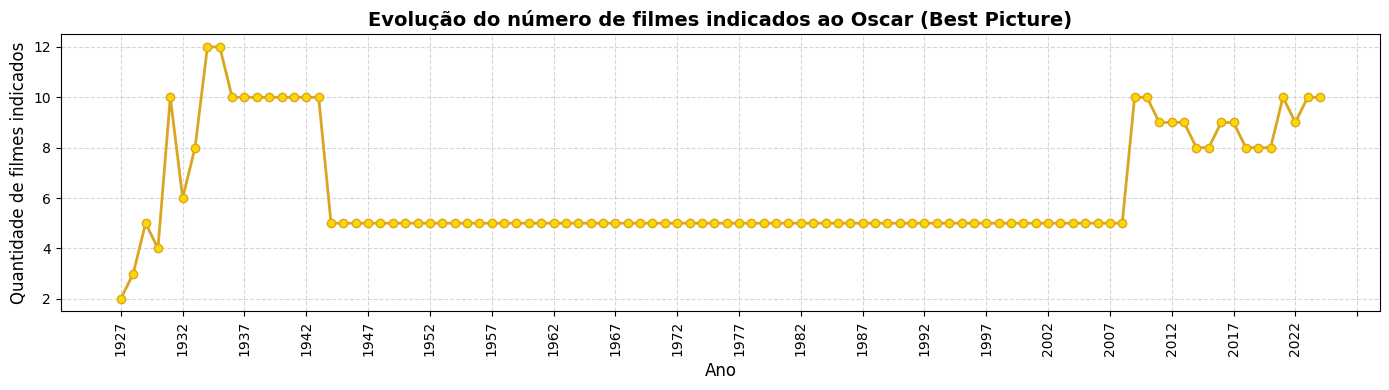

In [49]:
tabela_qtd_nomeados = (
    best_picture
    .groupby("Year")["Film"]
    .count()
    .reset_index()
    .rename(columns={"Year": "Ano", "Film": "Qtd_filmes_nomeados"})
)
print(tabela_qtd_nomeados)

plt.figure(figsize=(14,4))
plt.plot(
    tabela_qtd_nomeados["Ano"],
    tabela_qtd_nomeados["Qtd_filmes_nomeados"],
    color="#DAA520",         # linha dourada
    marker="o",
    markerfacecolor="#FFD700", # marcadores em ouro
    linewidth=2
)

plt.title("Evolução do número de filmes indicados ao Oscar (Best Picture)", fontsize=14, fontweight="bold", color="black")
plt.xlabel("Ano", fontsize=12)
plt.ylabel("Quantidade de filmes indicados", fontsize=12)

plt.xticks(rotation=90)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(5))  # rótulo a cada 5 anos
plt.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

No gráfico acima, é possível verificar que a quantidade de filmes indicados por edição da premiação não se manteve o mesmo entre a primeira e a última edição, em 1929 e 2025 respectivamente.

Fonte: https://en.wikipedia.org/wiki/Academy_Award_for_Best_Picture

De acordo com a fonte acima, essa observação está correta!

**Gráfico para Desbalanceamento**

**Os dados analisados apresentam um desbalanceamento natural**: em cada edição do Oscar na categoria Best Picture, existe apenas 1 vencedor enquanto há vários indicados. Isso significa que a classe “vencedor” é significativamente menor do que a classe “não vencedor”. Esse desbalanceamento deve ser considerado na modelagem, pois pode influenciar métricas de avaliação e levar os algoritmos a favorecerem a classe majoritária.

/tmp/ipython-input-2527043959.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  best_picture["Winner"] = best_picture["Winner"].fillna(False)


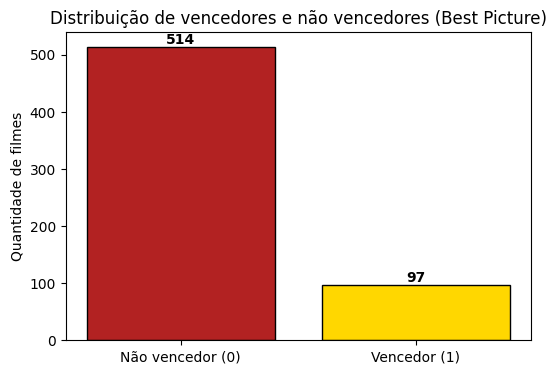

In [50]:
best_picture["Winner"] = best_picture["Winner"].fillna(False)

contagem = best_picture["Winner"].value_counts().sort_index()

plt.figure(figsize=(6,4))
barras = plt.bar(["Não vencedor (0)", "Vencedor (1)"], contagem, color=["#B22222","#FFD700"], edgecolor="black")
plt.title("Distribuição de vencedores e não vencedores (Best Picture)")
plt.ylabel("Quantidade de filmes")

# Adicionar rótulos em cima das barras
for barra in barras:
    altura = barra.get_height()
    plt.text(
        barra.get_x() + barra.get_width()/2,  # posição no eixo x
        altura,                               # posição no eixo y (em cima da barra)
        str(int(altura)),                     # texto (convertido em int para não mostrar decimal)
        ha='center', va='bottom', fontsize=10, fontweight='bold'
    )

plt.show()

**Distribuição da Duração, em minutos, dos Indicados**

In [51]:
dados_sem_duplicados["duration_min"] = dados_sem_duplicados["duration"].apply(parse_duration_to_minutes)

dados_sem_duplicados[['duration','duration_min']]


/tmp/ipython-input-2064203096.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_sem_duplicados["duration_min"] = dados_sem_duplicados["duration"].apply(parse_duration_to_minutes)


duration  duration_min
0     1h 44m           104
1     1h 54m           114
2     1h 28m            88
3      2h 9m           129
4     1h 50m           110
..       ...           ...
604   1h 50m           110
605   2h 41m           161
606   2h 35m           155
607   1h 48m           108
608   1h 48m           108

[608 rows x 2 columns]

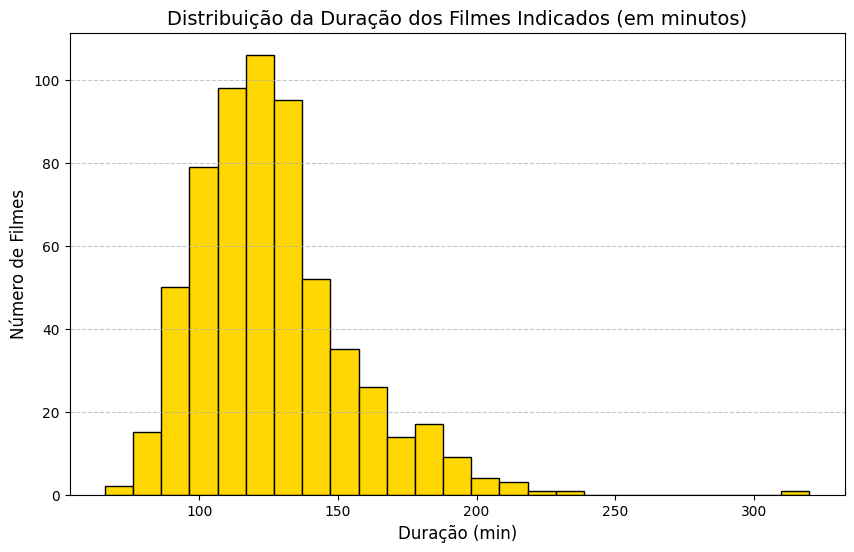

In [52]:
plt.figure(figsize=(10,6))
plt.hist(dados_sem_duplicados["duration_min"].dropna(), bins=25, color="#FFD700", edgecolor="black")
plt.title("Distribuição da Duração dos Filmes Indicados (em minutos)", fontsize=14)
plt.xlabel("Duração (min)", fontsize=12)
plt.ylabel("Número de Filmes", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

O histograma mostra que a maior parte dos filmes indicados ao Oscar de Melhor Filme tem duração entre 100 e aproximadamente 150 minutos, com concentração próxima de 2 horas.
A distribuição é relativamente simétrica em torno da média (~120 min), mas há filmes que ultrapassam 4 horas (outliers).
Filmes muito curtos são raros entre os indicados.


## 4. Definição do target, variáveis e divisão dos dados



In [53]:
df_indicados = dados_sem_duplicados.copy()
df_indicados.head(3)

Ceremony  Year  Class CanonicalCategory                Category      NomId  \
0        12  1939  Title      BEST PICTURE  OUTSTANDING PRODUCTION  an0047433   
1        12  1939  Title      BEST PICTURE  OUTSTANDING PRODUCTION  an0047434   
2        12  1939  Title      BEST PICTURE  OUTSTANDING PRODUCTION  an0047435   

                 Film     FilmId                         Name  \
0        Dark Victory  tt0031210  Warner Bros.-First National   
1  Goodbye, Mr. Chips  tt0031385          Metro-Goldwyn-Mayer   
2         Love Affair  tt0031593                    RKO Radio   

                       Nominees  ...  \
0  Warner Bros., First National  ...   
1           Metro-Goldwyn-Mayer  ...   
2                     RKO Radio  ...   

                                production_companies  \
0                                   ['Warner Bros.']   
1  ['Metro-Goldwyn-Mayer British Studios', "Loew's"]   
2                             ['RKO Radio Pictures']   

                                      awards_content  \
0  Nominated for 3 Oscars, 5 wins & 4 nominations...   
1          Won 1 Oscar, 6 wins & 8 nominations total   
2  Nominated for 6 Oscars, 3 wins & 6 nominations...   

                                              genres  \
0                               ['Drama', 'Romance']   
1                               ['Drama', 'Romance']   
2  ['Holiday Romance', 'Comedy', 'Drama', 'Romance']   

                        languages release_year          title_norm Year_num  \
0                     ['English']         1939        dark victory      NaN   
1  ['English', 'Latin', 'German']         1939  goodbye, mr. chips      NaN   
2           ['English', 'French']         1939         love affair      NaN   

  release_year_num diff_anos duration_min  
0              NaN       NaN          104  
1              NaN       NaN          114  
2              NaN       NaN           88  

[3 rows x 46 columns]

In [54]:
df_indicados.columns

Index(['Ceremony', 'Year', 'Class', 'CanonicalCategory', 'Category', 'NomId',
       'Film', 'FilmId', 'Name', 'Nominees', 'NomineeIds', 'Winner', 'Detail',
       'Note', 'Citation', 'MultifilmNomination', 'film_norm', 'id', 'title',
       'duration', 'MPA', 'rating', 'votes', 'meta_score', 'description',
       'movie_link', 'writers', 'directors', 'stars', 'budget',
       'opening_weekend_gross', 'gross_worldwide', 'gross_us_canada',
       'release_date', 'countries_origin', 'filming_locations',
       'production_companies', 'awards_content', 'genres', 'languages',
       'release_year', 'title_norm', 'Year_num', 'release_year_num',
       'diff_anos', 'duration_min'],
      dtype='object')

Antes de identificar o tipo de problema e a variável target, eliminarei as colunas que com certeza não serão utilizadas na predição dos vencedores da categoria Best Picture:

**NomId, FilmId, NomineeIds, id** → identificadores técnicos, sem valor informativo para o modelo.

**film_norm, title_norm, title** → diferentes versões do título do filme, redundantes entre si.

**movie_link** → apenas o endereço do IMDb, irrelevante para fins preditivos.

**Detail, Note, Citation** → anotações e comentários auxiliares.

**description** → sinopse textual do filme.

**Class, CanonicalCategory, Category** → redundantes,pois estão restrito à categoria Best Picture.

**duration** → redundante, já que duration_min é a representação numérica preparada para o modelo.

Além disso, as colunas a seguir serão eliminadas para **evitar data leakage**, uma vez que podem conter informações diretamente associadas ao resultado e levar o modelo a apenas “decorar” os vencedores ao invés de aprender padrões gerais:

**Ceremony, Year** → como há apenas um vencedor por ano/cerimônia, essas variáveis carregam a resposta e permitiriam ao modelo memorizar os resultados históricos. Também serão eliminadas as colunas **release_year, release_year_num, Year_num, diff_anos e release_date** que são redundantes e foram utilizadas no pré-processamento

**Name, Nominees, stars, writers, directors** → nomes de pessoas envolvidas (atores, diretores, produtores) podem ser diretamente associados a vitórias específicas.

Entre as variáveis relacionadas à dimensão geográfica e de produção, decidi manter apenas **countries_origin**, que indica os países de origem do filme.  

Sobre as variáveis de receita, optei por manter opening_weekend_gross (receita na semana de estreia) e gross_worldwide (receita global):

**gross_us_canada** → não é necessário manter um nível adicional de granularidade pois as outras variáveis já representam a performance financeira do filme.

In [55]:
cols_para_eliminar = [
    # Identificadores e redundâncias
    "NomId", "FilmId", "NomineeIds", "id",
    "film_norm", "title_norm", "title",
    "movie_link", "Detail", "Note", "Citation", "description", "duration", "MultifilmNomination",

    # Para evitar data leakage
    "Ceremony", "Year", "Name", "Nominees", "stars", "writers", "directors",
    "Class", "CanonicalCategory", "Category",
    "release_year", "release_year_num", "Year_num", "diff_anos", "release_date",

    # Informacoes geograficas
    "filming_locations", "production_companies", "languages",

    # Informacoes financeiras
    "gross_us_canada"
]

df_indicados.drop(columns=cols_para_eliminar, inplace=True)
df_indicados.columns

Index(['Film', 'Winner', 'MPA', 'rating', 'votes', 'meta_score', 'budget',
       'opening_weekend_gross', 'gross_worldwide', 'countries_origin',
       'awards_content', 'genres', 'duration_min'],
      dtype='object')

Analisando a presença de nulos e os tipos dos dados das colunas restantes:

In [56]:
df_indicados.info()

<class 'pandas.core.frame.DataFrame'>
Index: 608 entries, 0 to 608
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Film                   608 non-null    object 
 1   Winner                 96 non-null     object 
 2   MPA                    605 non-null    object 
 3   rating                 607 non-null    float64
 4   votes                  607 non-null    object 
 5   meta_score             477 non-null    float64
 6   budget                 499 non-null    object 
 7   opening_weekend_gross  309 non-null    object 
 8   gross_worldwide        444 non-null    object 
 9   countries_origin       608 non-null    object 
 10  awards_content         608 non-null    object 
 11  genres                 608 non-null    object 
 12  duration_min           608 non-null    int64  
dtypes: float64(2), int64(1), object(10)
memory usage: 66.5+ KB


Na base de dados analisada, dos **97 vencedores históricos do Oscar na categoria *Best Picture***, **96 estão presentes**, conforme indicado pela coluna **Winner**, que será utilizada como variável *target*.  

Entre as variáveis relacionadas à avaliação do público, destacam-se **rating** e **votes**.  
- A coluna **rating** representa a nota média atribuída pelos usuários, refletindo diretamente a percepção de qualidade do filme.  
- Já a coluna **votes** expressa apenas a quantidade de avaliações recebidas, funcionando como um indicador de popularidade, mas não necessariamente de qualidade.  

Assim, para fins de modelagem, **rating é mais significativa**, pois captura de forma direta a opinião agregada do público.  

A coluna **meta_score**, que corresponde à avaliação de críticos profissionais, **apresenta valores ausentes**. Para decidir sua utilização, **verificarei se os nulos correspondem a filmes vencedores**. Caso não correspondam, dado que a base já é desbalanceada (poucos vencedores em relação ao total de indicados), é aceitável excluir os filmes com valores nulos, preservando a consistência dos dados. **A mesma lógica será aplicada às colunas financeiras, como budget, opening_weekend_gross e gross_worldwide**.  


In [57]:
df_indicados[df_indicados["Winner"] == True]["meta_score"].info()

<class 'pandas.core.series.Series'>
Index: 96 entries, 9 to 591
Series name: meta_score
Non-Null Count  Dtype  
--------------  -----  
91 non-null     float64
dtypes: float64(1)
memory usage: 1.5 KB


In [58]:
df_indicados[df_indicados["Winner"] == True]["budget"].info()

<class 'pandas.core.series.Series'>
Index: 96 entries, 9 to 591
Series name: budget
Non-Null Count  Dtype 
--------------  ----- 
93 non-null     object
dtypes: object(1)
memory usage: 1.5+ KB


In [59]:
df_indicados[df_indicados["Winner"] == True]["opening_weekend_gross"].info()

<class 'pandas.core.series.Series'>
Index: 96 entries, 9 to 591
Series name: opening_weekend_gross
Non-Null Count  Dtype 
--------------  ----- 
55 non-null     object
dtypes: object(1)
memory usage: 1.5+ KB


In [60]:
df_indicados[df_indicados["Winner"] == True]["gross_worldwide"].info()

<class 'pandas.core.series.Series'>
Index: 96 entries, 9 to 591
Series name: gross_worldwide
Non-Null Count  Dtype 
--------------  ----- 
81 non-null     object
dtypes: object(1)
memory usage: 1.5+ KB


Foram adotadas estratégias distintas para lidar com os valores ausentes das colunas citadas anteriormente:

- **Manter:**
  - **meta_score**
  - **budget**
  - **gross_worldwide**

  Essas variáveis serão mantidas, pois contêm informação relevante para a modelagem.  Os valores ausentes serão tratados com **imputação por zero**, e será criada uma variável binária auxiliar (meta_score_missing, budget_missing, gross_worldwide_missing) indicando os casos em que o dado original estava ausente. Dessa forma, o modelo poderá considerar tanto o valor existente quanto o fato de a informação não estar disponível, o que pode ser informativo.

- **Excluir:**
  - **opening_weekend_gross**

  Essa variável apresenta **cobertura muito baixa entre os filmes vencedores** (apenas 55 dos 96 vencedores possuem o registro). A imputação não é adequada nesse caso, pois mais de 40% da classe positiva ficaria representada por valores artificiais. Por isso, a variável será excluída do conjunto de dados.

In [61]:
cols_para_eliminar_2 = ["opening_weekend_gross", "votes"]

# Drop das colunas
df_indicados.drop(columns=cols_para_eliminar_2, inplace=True)
df_indicados.columns

Index(['Film', 'Winner', 'MPA', 'rating', 'meta_score', 'budget',
       'gross_worldwide', 'countries_origin', 'awards_content', 'genres',
       'duration_min'],
      dtype='object')

In [62]:
df_indicados['MPA'].unique()

array(['Approved', 'G', 'R', 'PG', 'Not Rated', 'PG-13', 'Passed', None,
       'TV-MA', 'M/PG', 'TV-PG', 'Unrated'], dtype=object)

In [63]:
# Tipo de problema deste MVP: 'classificacao'
PROBLEM_TYPE = "classificacao"

# target binário (Winner: 1 = vencedor, 0 = indicado)
df_indicados["target_clf"] = df_indicados["Winner"].fillna(False).astype(int)

# definição de features
nao_features = {"target_clf", "Winner", "Film"}
features = [coluna for coluna in df_indicados.columns if coluna not in nao_features]
target = "target_clf"

print("PROBLEM_TYPE:", PROBLEM_TYPE)
print("Target:", target)
print("N features:", len(features))

# split estratificado, pois meus dados são desbalanceados
from sklearn.model_selection import train_test_split

X = df_indicados[features].copy()
y = df_indicados["target_clf"].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

print("Distribuição (y) total:\n", y.value_counts(normalize=True).rename("prop"))
print("Treino:", X_train.shape, "| Teste:", X_test.shape)
print("Distribuição treino:\n", y_train.value_counts(normalize=True).rename("prop"))
print("Distribuição teste:\n", y_test.value_counts(normalize=True).rename("prop"))



PROBLEM_TYPE: classificacao
Target: target_clf
N features: 9
Distribuição (y) total:
 target_clf
0    0.842105
1    0.157895
Name: prop, dtype: float64
Treino: (486, 9) | Teste: (122, 9)
Distribuição treino:
 target_clf
0    0.841564
1    0.158436
Name: prop, dtype: float64
Distribuição teste:
 target_clf
0    0.844262
1    0.155738
Name: prop, dtype: float64


/tmp/ipython-input-2617731269.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_indicados["target_clf"] = df_indicados["Winner"].fillna(False).astype(int)


**Comentários sobre: definição do target, variáveis e divisão dos dados**

- O *target* foi definido como classificação binária (**target_clf**), indicando vencedores (1) e não vencedores (0).  
- Foram selecionadas **9 variáveis preditoras (features)** para o modelo.  
- A base é **desbalanceada**, com cerca de **84% não vencedores** e **16% vencedores**, refletindo a realidade da premiação.  
- A divisão em treino (486 registros) e teste (122 registros), feita de forma **estratificada**, preservando essa proporção em ambos os conjuntos.  



## 5. Tratamento de dados e **Pipeline** de pré-processamento
Após a redução de dimensão, as colunas remanescentes precisam ser tratadas: há numéricos armazenados como object que devem ser convertidos para float e normalizados, variáveis categóricas devem ser codificadas, e colunas de missing flags antes de tratar dados nulos também serão criadas. Todas essas tranformações ficarão reunidas em um pipeline de pré-processamento, garantindo reprodutividade e evitando vazamento de dados. Abaixo, listo os transformers que serão criados:


In [64]:
df_indicados.columns

Index(['Film', 'Winner', 'MPA', 'rating', 'meta_score', 'budget',
       'gross_worldwide', 'countries_origin', 'awards_content', 'genres',
       'duration_min', 'target_clf'],
      dtype='object')

**Transformer para padronizar tipos de dados**

Para tratar paralelamente colunas de tipos diferentes (como financeiras e categóricas), precisarei usar o ColumnTransformer para ter um único fit/transform que concatene as saídas do Pipeline. Para isso, preciso garantir que cada ramo do ColumnTransformer receba um DataFrame com nomes de colunas, em vez de ndarray, para que steps que dependem de operações do pandas (ex.: .replace(), .isna()) e de nomes funcionem corretamente.

Além disso, vou utilizar a função get_feature_names_out após o pré-processamento de diversos Transformers (como seu último passo) para me ajudar na interpretabilidade final dos dados.

In [65]:
class AsDataFrame(BaseEstimator, TransformerMixin):
    """Converte ndarray -> DataFrame e preserva nomes para o Pipeline."""
    def __init__(self, columns=None):
        self.columns = columns  # não mutar no __init__

    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            self.columns_ = list(X.columns) if self.columns is None else list(self.columns)
        else:
            n = X.shape[1] if getattr(X, "ndim", 2) == 2 else 1
            self.columns_ = list(self.columns) if self.columns is not None else [f"col{i}" for i in range(n)]
        return self

    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            return X[self.columns_] if set(self.columns_).issubset(X.columns) else X.copy()
        X = np.asarray(X, dtype=object)
        if X.ndim == 1: X = X.reshape(-1, 1)
        return pd.DataFrame(X, columns=self.columns_)

    def get_feature_names_out(self, input_features=None):
        # Como não alteramos nomes, devolvemos os próprios nomes conhecidos
        return np.array(self.columns_, dtype=object)

**Transformer para tratar os dados financeiros:**

In [66]:
df_indicados['gross_worldwide'].unique()

array(['$345', None, '$146,123', '$2,477', '$25,637,669', '$624,643',
       '$231,976,425', '$60,611,975', '$273,552,592', '$8,835',
       '$227,514,205', '$17,009,654', '$26,657,534', '$68,706,993',
       '$57,779,280', '$76,729', '$49,259,766', '$31,431,652',
       '$2,923,710,708', '$210,888,950', '$321,460,744', '$309,231,694',
       '$735,102,136', '$166,842,739', '$44,135,556', '$20,616', '$8,072',
       '$12,180', '$2,264,812,968', '$314,178,011', '$257,938,649',
       '$126,216,940', '$19,522', '$27,669', '$1,475', '$105,017,915',
       '$56,666,797', '$378,411,362', '$335,802,786', '$368,875,760',
       '$23,240,144', '$31,853,080', '$40,084,041', '$17,504,819',
       '$21,062,065', '$36,000,000', '$217', '$272,742,922',
       '$451,291,298', '$49,114,016', '$205,405,498', '$74,787,599',
       '$4,727,083', '$12,729,675', '$389,925,971', '$40,382,788',
       '$4,553', '$1,433', '$184,240', '$5,014,000', '$32,653,977',
       '$81,640,278', '$35,000,000', '$6,258,7

In [67]:
df_indicados['budget'].unique()

array([None, '$1,900,000 (estimated)', '$1,365,000 (estimated)',
       '$392,000 (estimated)', '$2,777,000 (estimated)',
       '$1,200,000 (estimated)', '$27,000,000 (estimated)',
       '$7,000,000 (estimated)', '$50,000,000 (estimated)',
       '$600,000 (estimated)', '$1,645,000 (estimated)',
       '$300,000 (estimated)', '$2,800,000 (estimated)',
       '$4,000,000 (estimated)', '$762,000 (estimated)',
       '$952,000 (estimated)', '$1,173,639 (estimated)',
       '$31,000,000 (estimated)', '$16,000,000 (estimated)',
       '$12,000,000 (estimated)', '$1,000,000 (estimated)',
       '$44,000,000 (estimated)', '$15,000,000 (estimated)',
       '$240,000 (estimated)', '$237,000,000 (estimated)',
       '$30,000,000 (estimated)', '$70,000,000 (estimated)',
       '$29,000,000 (estimated)', '$175,000,000 (estimated)',
       '$25,000,000 (estimated)', '$6,000,000 (estimated)',
       '$2,125,000 (estimated)', '$3,000,000 (estimated)',
       '$200,000,000 (estimated)', '$3,500,000 

As colunas financeiras possuem dados do tipo object em moedas diferentes (por exemplo dólar e libra) e, no caso do orçamento, possuem ainda a string " (estimated)", o que dificulta a conversão do valor em variável numérica. Por isso, estou optando por padronizar as colunas financeiras para:
1. Remover dados que não são em dólar: transformá-los em nulo
2. Remover a string " (estimated)"
3. Remover possíveis vírgulas
4. Manter dados nulos como nulos

In [68]:
class FinancialCleaner(BaseEstimator, TransformerMixin):
    """
    Limpa colunas financeiras:
      - None/NaN -> np.nan
      - remove ' (estimated)'
      - se começa com '$' -> remove '$' e vírgulas; mantém string numérica
      - caso contrário -> np.nan
    """
    def fit(self, X, y=None):
        # guardar nomes das colunas se vier DataFrame
        if isinstance(X, pd.DataFrame):
            self.feature_names_in_ = list(X.columns)
        else:
            self.feature_names_in_ = None
        return self

    def _clean_scalar(self, v):
        if v is None or (isinstance(v, float) and np.isnan(v)) or (isinstance(v, pd.Series) and pd.isna(v)):
            return np.nan
        s = str(v).strip()
        if not s:
            return np.nan
        s = s.replace(" (estimated)", "")
        if s.startswith("$"):
            s = s[1:].replace(",", "")
            return s if s else np.nan
        return np.nan

    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            cleaned = X.map(self._clean_scalar).astype("object")
            return cleaned.values
        X = np.asarray(X, dtype=object) # caso de entrada ndarray: dtype=object para suportar strings e NaNs juntos.
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        nrows, ncols = X.shape
        out = np.empty((nrows, ncols), dtype=object) # garantindo que saida tera mesmo shape
        for j in range(ncols):
            col = X[:, j]
            out[:, j] = [self._clean_scalar(v) for v in col] # aplicando as regras para tratar as colunas financeiras
        return out

    def get_feature_names_out(self, input_features=None):
        if input_features is not None:  # o pipeline já disse os nomes → uso estes
            return np.array(input_features, dtype=object)
        if getattr(self, "feature_names_in_", None) is not None:  # guardei nomes no fit → uso estes
            return np.array(self.feature_names_in_, dtype=object)
        return np.array([], dtype=object)   # não tenho nomes confiáveis → devolvo vazio com segurança

**Como sugerido nos requisitos deste MVP, criarei visões diferentes do dataset gerando os cenários SEM e COM a normalização destas colunas** e, para isso, usarei a classe MinMaxScaler. Portando, as colunas budget e gross_worldwide ainda precisam passar pelos seguintes tratamentos:
1. Converter de object para float
2. Preencher os nulos com 0
3. MinMaxScaler

**Transformer para criar colunas _missing**

Para agregar mais informações ao modelo, ao invés de simplesmente tratar os valores nulos das features, criarei colunas binárias para sinalizar se aquela informação era faltante ou não. Assim, para uma feature original (por exemplo budget), passaremos a ter duas features (o próprio budget e a informação se aquele valor é ou não tratado).

In [69]:
class MissingValues(BaseEstimator, TransformerMixin):
    """
    Retorna: [colunas originais] + [<col>_missing (0/1)].
    """
    def __init__(self, cols=None):
        self.cols = cols

    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            self.cols_ = list(self.cols) if self.cols is not None else list(X.columns)  # se receber os nomes das colunas, usa elas; senão, usa todas as colunas do X
        else:
            raise ValueError("X precisa ser DataFrame para usar MissingValues")
        return self

    def transform(self, X):
        X_out = X.copy()
        for c in self.cols_:
            X_out[c + "_missing"] = X_out[c].isna().astype(int) # criando coluna binaria para a feature original
        return X_out

    def get_feature_names_out(self, input_features=None):
        return np.array(list(self.cols_) + [c + "_missing" for c in self.cols_], dtype=object)

**Transformer para colunas do tipo Object:**

****
**Coluna MPA**

In [70]:
df_indicados['MPA'].unique()

array(['Approved', 'G', 'R', 'PG', 'Not Rated', 'PG-13', 'Passed', None,
       'TV-MA', 'M/PG', 'TV-PG', 'Unrated'], dtype=object)

Abaixo, transformer criado para unificar a categoria sem classificação (Not Rated, Unrated e até mesmo nulos). A função replace_values_mpa está definida no início deste MVP.

In [71]:
replacer_mpa = FunctionTransformer(replace_values_mpa)

****
**Coluna countries_origin**

In [72]:
df_indicados['countries_origin'].unique()

array(["['United States']", "['United Kingdom', 'United States']",
       "['United States', 'United Kingdom']",
       "['Brazil', 'United States']", "['United Kingdom']",
       "['United States', 'Switzerland']",
       "['United States', 'Luxembourg', 'Canada']",
       "['United Kingdom', 'France', 'United States']",
       "['South Africa', 'United States', 'New Zealand', 'Canada']",
       "['United States', 'Germany']",
       "['United Kingdom', 'France', 'United States', 'India']",
       "['United States', 'Japan']", "['United States', 'France']",
       "['France', 'Canada']",
       "['United States', 'United Kingdom', 'Malta', 'Morocco']",
       "['Australia', 'United States', 'United Kingdom']",
       "['United Kingdom', 'United States', 'Australia']",
       "['United States', 'Mexico']", "['United States', 'Canada']",
       "['United States', 'Greece']",
       "['Italy', 'United Kingdom', 'United States']",
       "['United Kingdom', 'France']", "['United States', 

A origem do filme (ser ou não americano) pode carregar informações úteis para o modelo, por isso, essa coluna será usada para gerar duas flags a partir da lista de países por filme:

national_film = 1 se a lista contiver 'United States', 'USA' ou 'US'; senão 0.

international_film = 0 apenas quando o único país é um desses de US; caso contrário 1.

Casos sem informação serão tratados com -1 para não contaminar nulos como filmes internacionais.

In [73]:
class CountryFlagsSimple(BaseEstimator, TransformerMixin):
    def __init__(self, col='countries_origin'):
        self.col = col
        self._us_aliases = {'United States', 'USA', 'US'}  # valores considerados "EUA"

    def fit(self, X, y=None):
        self.feature_names_out_ = np.array(['national_film', 'international_film'], dtype=object) # nomes das duas saídas deste transformer
        return self

    def transform(self, X):
        countries_series = X[self.col] if isinstance(X, pd.DataFrame) else pd.Series(X.ravel()) # pega a coluna como Series (aceita DataFrame ou array)

        national_flags, international_flags = [], []  # acumuladores
        for cell_value in countries_series:
            # obtendo a lista de países desta célula
            if pd.isna(cell_value):
                country_list = None  # sem informação
            elif isinstance(cell_value, (list, tuple)):
                country_list = [str(country).strip() for country in cell_value]  # é uma lista
            else:
                try:
                  # tentando converter o texto que parece lista ("['..', '..']")
                    parsed = ast.literal_eval(cell_value)
                    country_list = [str(country).strip() for country in parsed] \
                                   if isinstance(parsed, (list, tuple)) else None
                except Exception:
                    country_list = None  # não deu para interpretar

            # 2) Regras das flags
            if not country_list:  # vazio/None
                national_flags.append(-1)  # tratando vazios como -1
                international_flags.append(-1)
                continue

            # tem um dos valores que identificam os USA?
            has_us = any(country in self._us_aliases for country in country_list)
            # internacional = 0 só quando o unico país da lista é USA
            only_us = has_us and len(country_list) == 1

            national_flags.append(1 if has_us else 0) # 1 se identificou USA, 0 caso contrario
            international_flags.append(0 if only_us else 1) # o se só identificou USA, 1 caso contrario

        # retorna uma lista como coluna de tamanho (n, 2) onde n é a quantidade de linhas nos dados e 2 sao as colunas
        return np.column_stack([national_flags, international_flags])

    def get_feature_names_out(self, input_features=None):
        # nomes das duas colunas geradas
        return self.feature_names_out_

****
**Coluna awards_content**

In [74]:
df_indicados['awards_content'].unique()

array(['Nominated for 3 Oscars, 5 wins & 4 nominations total',
       'Won 1 Oscar, 6 wins & 8 nominations total',
       'Nominated for 6 Oscars, 3 wins & 6 nominations total',
       'Won 1 Oscar, 8 wins & 12 nominations total',
       'Nominated for 4 Oscars, 5 wins & 6 nominations total',
       'Won 2 Oscars, 10 wins & 5 nominations total',
       'Won 2 Oscars, 15 wins & 15 nominations total',
       'Won 1 Oscar, 9 wins & 7 nominations total',
       'Won 1 Oscar, 6 wins & 3 nominations total',
       'Won 9 Oscars, 62 wins & 78 nominations total',
       'Won 2 Oscars, 84 wins & 58 nominations total',
       'Won 1 Oscar, 26 wins & 41 nominations total',
       'Won 3 Oscars, 11 wins & 7 nominations total',
       'Won 1 Oscar, 7 wins & 5 nominations total',
       'Won 1 Oscar, 8 wins & 6 nominations total',
       'Nominated for 4 Oscars, 1 win & 4 nominations total',
       'Won 2 Oscars, 7 wins & 3 nominations total',
       'Won 2 Oscars, 6 wins & 6 nominations total',
   

É possível observar que as entradas de awards_content seguem um padrão para quantificar indicações (“… wins & N nomination(s) total”). Então, posso extrair o número de nomeações aplicando uma regra simples: capturo **o valor que aparece logo após & e antes de “nomination/nominationS”**. Depois, converto para número e trato ausências com -1, para diferenciar falta de informação (nulo = -1) de filmes com 0 indicações reais (valor 0).

In [75]:
class AwardsNominationsExtractor(BaseEstimator, TransformerMixin):
    """
    Extrai o número de nomeações de strings:
    """
    def __init__(self, col='awards_content', out_col='nominations'):
        self.col = col
        self.out_col = out_col
        # retorna os caracteres entre o & e "nomination", que é a quantidade de nomeaçoes
        self.re_nominations = re.compile(r"&\s*(\d+)\s+nomination", flags=re.I)

    def fit(self, X, y=None):
        self.feature_names_out_ = np.array([self.out_col], dtype=object)
        return self

    def _extract(self, text):
        if pd.isna(text):
            return np.nan
        s = str(text)
        m = self.re_nominations.search(s) # executando o método search do atributo re_nominations
        return m.group(1) if m else np.nan  # retorna o texto capturado por (\d+) ou NaN

    def transform(self, X):
        series = X[self.col] if isinstance(X, pd.DataFrame) else pd.Series(X.ravel())
        out = series.map(self._extract).astype(object)  # executando _extract para cada elemento
        return out.to_numpy().reshape(-1, 1)

    def get_feature_names_out(self, input_features=None):
        return self.feature_names_out_

****
**Coluna genres**

In [76]:
df_indicados['genres'].unique()

array(["['Drama', 'Romance']",
       "['Holiday Romance', 'Comedy', 'Drama', 'Romance']",
       "['Political Drama', 'Comedy', 'Drama']",
       "['Romantic Comedy', 'Satire', 'Screwball Comedy', 'Comedy', 'Romance']",
       "['Classical Western', 'Adventure', 'Drama', 'Western']",
       "['Adventure Epic', 'Classic Musical', 'Fairy Tale', 'Fantasy Epic', 'Quest', 'Adventure', 'Family', 'Fantasy', 'Musical']",
       "['Desert Adventure', 'Period Drama', 'Romantic Epic', 'Steamy Romance', 'Tragedy', 'Tragic Romance', 'Drama', 'Romance', 'War']",
       "['Cop Drama', 'Dark Comedy', 'Police Procedural', 'Tragedy', 'Crime', 'Drama', 'Thriller']",
       "['Feel-Good Romance', 'Football', 'Romantic Comedy', 'Workplace Drama', 'Comedy', 'Drama', 'Romance', 'Sport']",
       "['Biography', 'Drama']",
       "['Romantic Comedy', 'Screwball Comedy', 'Comedy', 'Romance']",
       "['Sea Adventure', 'Adventure', 'Drama', 'Family']",
       "['Film Noir', 'Crime', 'Drama', 'Romance']",
     

De acordo com a coluna 'genres', o mesmo filme possui mais de um gênero associado. Além disso, os gêneros são extremamente detalhados, o que torna difícil e de alta granulosidade a utilização do One-Hot-Encoder. A minha alternativa é de tentar listar os principais gêneros dos filmes da seguinte forma: **Comédia, Romance, Drama, Biografia, Thriller, Ação**, além de **Outros**, preservando a caracteristica do título poder se enquadrar em mais de um gênero. Dessa forma, Others = 1 indica que existe um gênero associado ao título que não está listado entre os gêneros específicos identificados nesse MVP. Por outro lado, casos com entrada nula serão tratados com Others = -1, para poder diferenciar dos demais gêneros não listados.

In [77]:
class GenresMultiHotEncoder(BaseEstimator, TransformerMixin):
    """
    Lê 'genres' como string no formato "['G1','G2',...]" e cria colunas binárias para Comedy, Romance, Drama, Biography, Thriller, Action, Others.
    """

    def __init__(self, col='genres'):
        self.col = col
        self.output_columns_ = ['genre_comedy','genre_romance','genre_drama','genre_biography','genre_thriller','genre_action','genre_others']
        # grafia em minusculo para as categorias específicas
        self.keyword_by_column_ = {
            'genre_comedy':    'comedy',
            'genre_romance':   'romance',
            'genre_drama':     'drama',
            'genre_biography': 'biography',
            'genre_thriller':  'thriller',
            'genre_action':    'action',
        }

    def fit(self, X, y=None):
        self.feature_names_out_ = np.array(self.output_columns_, dtype=object)
        return self

    def transform(self, X):
        genres_series = X[self.col] if isinstance(X, pd.DataFrame) else pd.Series(X.ravel())
        rows_flags = []

        # pegando o valor, ignorando o index
        for cell_text in genres_series:
            if pd.isna(cell_text): # tranformando nulos em uma lista vazia
                raw_list = []
            else:
                try:
                    parsed = ast.literal_eval(cell_text)   # interpretando literais
                    raw_list = list(parsed) if isinstance(parsed, (list, tuple)) else [str(parsed)] # convertendo as entradas para lista
                except Exception:
                    raw_list = []

            genres_norm = [str(g).strip().lower() for g in raw_list if str(g).strip()] # normaliza as entradas nao nulas, convertendo para string, eliminando espaços e tornando as letras minúsculas

            flags = {name: 0 for name in self.output_columns_} # inicializando as colunas de saída com 0

            # Tratando as colunas 'Comedy','Romance','Drama','Biography','Thriller','Action'
            for col_name, keyword in self.keyword_by_column_.items(): # iterando nos generos de saída
                flags[col_name] = int(any(keyword in g for g in genres_norm)) # altera para 1 as colunas de gêneros específicos cujo gênero normalizado foi identificado

            # Tratando a coluna Others
            if genres_norm:  # verificando se a lista de gêneros normalizados não é nula
                # para cada gênero normalizado, procura pelos gêneros específicos.
                is_known = [any(k in g for k in self.keyword_by_column_.values()) for g in genres_norm] # retorna uma lista de booleanos
                flags['Others'] = int(any(not ok for ok in is_known)) # retorna 1 se existir um False em is_know (ou seja, uma dos gêneros normalizados não está listado nos gêneros específicos)
            else:
                flags['Others'] = -1 # tratando nulos com -1 para diferenciar dos demais gêneros não identificados

            rows_flags.append([flags[c] for c in self.output_columns_]) #preenchendo a lista rows_flags na ordem das colunas de saída

        # 7) retorna matriz (n, 7) 0/1 para o ColumnTransformer concatenar
        return np.asarray(rows_flags, dtype=int) # tranforma uma matriz com shape (n, 7) e 0s e 1s

    def get_feature_names_out(self, input_features=None):
        return self.feature_names_out_

**Transformer para fazer o cast para float**

In [78]:
def cast_para_float(x):
    # recebe DataFrame (ou ndarray) e devolve DataFrame
    df = x if isinstance(x, pd.DataFrame) else pd.DataFrame(x)
    df = df.copy()
    # converte só as colunas que NÃO são flags *_missing
    cols_to_cast = [c for c in df.columns]
    for c in cols_to_cast:
        df[c] = pd.to_numeric(df[c], errors='coerce').astype(float)
    return df

### Criando os Pipelines de Pré-processamento dos dados **SEM** e **COM** a normalização das colunas financeiras

In [79]:
replacer_mpa = FunctionTransformer(replace_values_mpa, validate=False, feature_names_out="one-to-one")
conv_2_float = FunctionTransformer(cast_para_float, validate=False, feature_names_out="one-to-one")


# separando os dados para os pipelines
cat_cols_to_clean = ['MPA']
fin_cols = ['budget', 'gross_worldwide']
fin_cols_missing = [f'{c}_missing' for c in fin_cols] #nome das colunas financeiras booleanas
all_fin_cols = fin_cols + fin_cols_missing #nome de todas as colunas dos dados booleanos
num_cols = ['meta_score', 'rating', 'duration_min']



# pipeline da coluna MPA
cat_pipe = Pipeline([
    ('to_df', AsDataFrame(columns=cat_cols_to_clean)),   # agora tem get_feature_names_out
    ('replace', replacer_mpa),                            # e também tem nomes
    ('imputer', SimpleImputer(strategy='most_frequent')), # tem nomes no sklearn recente
    ('ohe', OneHotEncoder(handle_unknown='ignore')),  # último step -> nomes do OHE
])

# pipeline das colunas financeiras SEM normalização
fin_pipe_SEM_norm = Pipeline([
    ('to_df_fin1', AsDataFrame(columns=fin_cols)), # fornece nomes ao cleaner
    ('fin_clean', FinancialCleaner()), # aplicar tratamento nos dados financeiros
    ('to_df_fin2', AsDataFrame(columns=fin_cols)), # fornecer nomes novamente
    ('flags_fin', MissingValues(cols=fin_cols)), # criar coluna booleana _missing
    ('cast_fin', conv_2_float), # convertendo os valores para float
    ('imp_fin', SimpleImputer(strategy='constant', fill_value=0.0)),  # imputando 0.0 nos valores faltantes
    ('to_df_fin3', AsDataFrame(columns=all_fin_cols)) # fornecendo tbm os nomes das colunas _missing
])

# pipeline das colunas financeiras COM normalização
fin_pipe_COM_norm = Pipeline([
    ('to_df_fin1', AsDataFrame(columns=fin_cols)), # fornece nomes ao cleaner
    ('fin_clean', FinancialCleaner()), # aplicar tratamento nos dados financeiros
    ('to_df_fin2', AsDataFrame(columns=fin_cols)), # fornecer nomes novamente
    ('flags_fin', MissingValues(cols=fin_cols)), # criar coluna booleana _missing
    ('cast_fin', conv_2_float), # convertendo os valores para float
    ('imp_fin', SimpleImputer(strategy='constant', fill_value=0.0)),  # imputando 0.0 nos valores faltantes
    ('to_df_fin3', AsDataFrame(columns=all_fin_cols)), # fornecendo tbm os nomes das colunas _missing
    ('scale_fin',  ColumnTransformer(
        transformers=[('mm', MinMaxScaler(), fin_cols)],       # normalizando as colunas budget e gross_worldwide (ignorando as _missing)
        remainder='passthrough',
        verbose_feature_names_out=False
    )),
    ('to_df_fin4', AsDataFrame(columns=all_fin_cols)),  # recupera nomes após o CT interno
])

# pipeline das colunas numéricas
num_pipe = Pipeline([
    ('to_df_num1', AsDataFrame(columns=num_cols)), # MissingValues precisa de DF
    ('flags_num', MissingValues(cols=num_cols)), # criar coluna booleana _missing
    ('cast_num', conv_2_float),
    ('imp_num', SimpleImputer(strategy='constant', fill_value=0.0)), # imputando 0.0 nos valores faltantes
    ('to_df_num2', AsDataFrame(columns=num_cols + [f'{c}_missing' for c in num_cols]))
])

# pipeline da coluna dos países
country_pipe = Pipeline([
    ('to_df_country', AsDataFrame(columns=['countries_origin'])),
    ('flags_country', CountryFlagsSimple(col='countries_origin')),
])

# pipeline da coluna das nomeações
awards_pipe = Pipeline([
    ('to_df_aw', AsDataFrame(columns=['awards_content'])),
    ('noms', AwardsNominationsExtractor(col='awards_content', out_col='nominations')),
    ('to_df_aw2', AsDataFrame(columns=['nominations'])),     # dá nome à saída (ndarray -> DF)
    ('cast_nom', conv_2_float),
    ('imp_nom',   SimpleImputer(strategy='constant', fill_value=-1.0)),
])

# pipeline da coluna dos gêneros
genres_pipe = Pipeline([
    ('to_df_gen', AsDataFrame(columns=['genres'])),  # garante DataFrame com nome de coluna
    ('genres_bin', GenresMultiHotEncoder(col='genres')),  # cria Comedy, Romance, ... , Others
])


### **Criando Visões Diferentes dos Dataset:**

Ainda para atender o checklist do MVP, além de avaliar os pipelines com e sem normalização de variáveis, avaliarei também o impacto de realizar feature selection. Dessa forma, terei 4 pipelines resultantes:

**Pipeline 1:** sem normalização, sem seleção de atributos (baseline).

**Pipeline 2:** sem normalização, com seleção de atributos.

**Pipeline 3:** com normalização, sem seleção de atributos.

**Pipeline 4:** com normalização, com seleção de atributos.

In [80]:
#Criando a visão SEM normalização
preprocess_SEM_norm = ColumnTransformer(
    transformers=[
        ('fin_clean', fin_pipe_SEM_norm, fin_cols),
        ('cat_clean', cat_pipe, cat_cols_to_clean),
        ('num_clean', num_pipe, num_cols),
        ('country_clean', country_pipe, ['countries_origin']),
        ('awards_clean', awards_pipe, ['awards_content']),
        ('genres_clean', genres_pipe, ['genres'])
    ],
    remainder='drop',
    verbose_feature_names_out=False
)

#Criando a visão SEM normalização + feature selection
preprocess_SEM_norm_SEL = Pipeline(steps=[
    ("preprocess", preprocess_SEM_norm),
    ("select", SelectKBest(score_func=f_classif, k=15))   # ajuste k conforme necessário
])

#Criando a visão COM normalização
preprocess_COM_norm = ColumnTransformer(
    transformers=[
        ('fin_clean', fin_pipe_COM_norm, fin_cols),  # pipeline das colunas financeiras COM normalização
        ('cat_clean', cat_pipe, cat_cols_to_clean),
        ('num_clean', num_pipe, num_cols),
        ('country_clean', country_pipe, ['countries_origin']),
        ('awards_clean', awards_pipe, ['awards_content']),
        ('genres_clean', genres_pipe, ['genres']),
    ],
    remainder='drop',
    verbose_feature_names_out=False
)

#Criando a visão COM normalização + feature selection
preprocess_COM_norm_SEL = Pipeline(steps=[
    ("preprocess", preprocess_COM_norm),
    ("select", SelectKBest(score_func=f_classif, k=15))
])


In [81]:
preprocess_SEM_norm_SEL.fit(X_train, y_train)
rep_sem_norm_sel = selected_features_with_scores(preprocess_SEM_norm_SEL)

/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [18 19 29] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [82]:
rep_sem_norm_sel.head(15)

feature      score  selected
14               meta_score  24.332434      True
2            budget_missing  18.076760      True
17       meta_score_missing  17.185836      True
16             duration_min  13.476162      True
3   gross_worldwide_missing   7.972711      True
15                   rating   7.272085      True
5                     MPA_G   6.555518      True
4              MPA_Approved   2.230984      True
10                    MPA_R   2.111738      True
0                    budget   1.650277      True
9                MPA_Passed   0.816463      True
1           gross_worldwide   0.704861      True
8                 MPA_PG-13   0.616252      True
23             genre_comedy   0.529458      True
25              genre_drama   0.527702      True

### **Validação Cruzada: Usar ou não?**

Como discutido anteriormente, por ser um dataset desbalanceado, é interessante aplicar algum método de validação cruzada para reduzir a variância das métricas e para tornar os dados menos sensíveis ao split único.


## 6. Baseline e modelos candidatos
Para estabelecer uma referência mínima de desempenho, **o baseline escolhido é o DummyClassifier** com a estratégia *most_frequent*. Esse classificador ignora os atributos preditivos e sempre prevê a classe majoritária, o que o torna uma boa opção de baseline em problemas de classificação desbalanceados, como é o caso do meu dataset.

Além do baseline, avaliarei dois modelos supervisionados bastante utilizados em problemas de classificação:

1. **Logistic Regression:** modelo linear, simples e interpretável, que servirá como primeiro comparativo em relação ao baseline. Para compensar o desbalanceamento, usarei a opção *class_weigth="balanced"*, que ajusta o peso de cada classe de acordo com a sua frequência (no caso, a classe minoritária (1 - vencedor) recebe maior peso, quando comparada com a classe majoritária (0 - indicado)).

2. **XGBoost:** algoritmo baseado em gradient boosting, reconhecido por seu bom desempenho em dados tabulares e pela capacidade de lidar com desbalanceamento de classes através do parâmetro *scale_pos_weight* (razão entre a quantidade de instâncias negativas e positivas).

Estes dois modelos serão executados em **quatro versões do pipeline de pré-processamento**, combinando a presença ou não de normalização e seleção de atributos.


In [83]:
baseline = Pipeline(steps=[
    ("pre", preprocess_SEM_norm),
    ("model", DummyClassifier(strategy="most_frequent", random_state=SEED))
])

baseline

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('fin_clean',
                                                  Pipeline(steps=[('to_df_fin1',
                                                                   AsDataFrame(columns=['budget',
                                                                                        'gross_worldwide'])),
                                                                  ('fin_clean',
                                                                   FinancialCleaner()),
                                                                  ('to_df_fin2',
                                                                   AsDataFrame(columns=['budget',
                                                                                        'gross_worldwide'])),
                                                                  ('flags_fin',
                                                                   MissingValues(cols=['budget',
                                                                                       'gross_worldwide'])),
                                                                  ('cast_fin',
                                                                   FunctionTransformer(feature_...
                                                                                       func=<function cast_para_float at 0x7888752bec00>)),
                                                                  ('imp_nom',
                                                                   SimpleImputer(fill_value=-1.0,
                                                                                 strategy='constant'))]),
                                                  ['awards_content']),
                                                 ('genres_clean',
                                                  Pipeline(steps=[('to_df_gen',
                                                                   AsDataFrame(columns=['genres'])),
                                                                  ('genres_bin',
                                                                   GenresMultiHotEncoder())]),
                                                  ['genres'])],
                                   verbose_feature_names_out=False)),
                ('model',
                 DummyClassifier(random_state=42, strategy='most_frequent'))])

In [84]:
#calculando o scale_pos_weight para o XGBoost:
pos = np.sum(y_train == 1)
neg = np.sum(y_train == 0)
spw = neg/pos

candidates = {
    #Logistic Regression
    "LogReg_SEM_norm": Pipeline([
        ("pre", preprocess_SEM_norm),
        ("model", LogisticRegression(max_iter=200, class_weight="balanced", random_state=SEED))
    ]), #não normalizado e sem feature selection
    "LogReg_SEM_norm_SEL": Pipeline([
        ("pre", preprocess_SEM_norm_SEL),
        ("model", LogisticRegression(max_iter=200, class_weight="balanced", random_state=SEED))
    ]), #não normalizado e com feature selection
    "LogReg_COM_norm": Pipeline([
        ("pre", preprocess_COM_norm),
        ("model", LogisticRegression(max_iter=200, class_weight="balanced", random_state=SEED))
    ]), #normalizado e sem feature selection
    "LogReg_COM_norm_SEL": Pipeline([
        ("pre", preprocess_COM_norm_SEL),
        ("model", LogisticRegression(max_iter=200, class_weight="balanced", random_state=SEED))
    ]), #normalizado e com feature selection

    # ---- XGBoost (configuração básica, pouquíssimos parâmetros) ----
    "XGB_SEM_norm": Pipeline([
        ("pre", preprocess_SEM_norm),
        ("model", XGBClassifier(random_state=SEED, eval_metric="logloss", scale_pos_weight=spw))
    ]), #não normalizado e sem feature selection
    "XGB_SEM_norm_SEL": Pipeline([
        ("pre", preprocess_SEM_norm_SEL),
        ("model", XGBClassifier(random_state=SEED, eval_metric="logloss", scale_pos_weight=spw))
    ]), #não normalizado e com feature selection
    "XGB_COM_norm": Pipeline([
        ("pre", preprocess_COM_norm),
        ("model", XGBClassifier(random_state=SEED, eval_metric="logloss", scale_pos_weight=spw))
    ]), #normalizado e sem feature selection
    "XGB_COM_norm_SEL": Pipeline([
        ("pre", preprocess_COM_norm_SEL),
        ("model", XGBClassifier(random_state=SEED, eval_metric="logloss", scale_pos_weight=spw))
    ]), #normalizado e com feature selection
}

In [85]:
#printando um dos candidatos como exemplo
candidates['LogReg_COM_norm']

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('fin_clean',
                                                  Pipeline(steps=[('to_df_fin1',
                                                                   AsDataFrame(columns=['budget',
                                                                                        'gross_worldwide'])),
                                                                  ('fin_clean',
                                                                   FinancialCleaner()),
                                                                  ('to_df_fin2',
                                                                   AsDataFrame(columns=['budget',
                                                                                        'gross_worldwide'])),
                                                                  ('flags_fin',
                                                                   MissingValues(cols=['budget',
                                                                                       'gross_worldwide'])),
                                                                  ('cast_fin',
                                                                   FunctionTransformer(feature_...
                                                                                       func=<function cast_para_float at 0x7888752bec00>)),
                                                                  ('imp_nom',
                                                                   SimpleImputer(fill_value=-1.0,
                                                                                 strategy='constant'))]),
                                                  ['awards_content']),
                                                 ('genres_clean',
                                                  Pipeline(steps=[('to_df_gen',
                                                                   AsDataFrame(columns=['genres'])),
                                                                  ('genres_bin',
                                                                   GenresMultiHotEncoder())]),
                                                  ['genres'])],
                                   verbose_feature_names_out=False)),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=200,
                                    random_state=42))])


### 6.1 Treino e avaliação rápida (baseline vs candidatos)

Nesta etapa realizarei uma **avaliação rápida** dos modelos candidatos em comparação ao baseline. Cada modelo será treinado no conjunto de treino e avaliado no conjunto de teste (holdout simples), **sem validação cruzada ou ajuste de hiperparâmetros**.  

O objetivo é apenas **comparar o desempenho inicial** dos diferentes modelos (Logistic Regression e XGBoost) em suas quatro versões de pipeline de pré-processamento, verificando se superam o baseline (DummyClassifier com estratégia *most_frequent*).  

Com base nessa análise inicial, escolherei **qual modelo e qual pipeline têm maior potencial**, para então aplicar posteriormente **validação cruzada e otimização de hiperparâmetros**.


In [86]:
results = {}

# --- Baseline
t0 = time.time()
baseline.fit(X_train, y_train)
t1 = time.time()
y_pred = baseline.predict(X_test)
proba  = baseline.predict_proba(X_test) if hasattr(baseline, "predict_proba") else None
results["baseline"] = evaluate_classification(y_test, y_pred, proba)
results["baseline"]["train_time_s"] = round(t1 - t0, 3)

# --- Candidatos
for name, pipe in candidates.items():
    t0 = time.time()
    pipe.fit(X_train, y_train)
    t1 = time.time()
    y_pred = pipe.predict(X_test)
    proba  = pipe.predict_proba(X_test) if hasattr(pipe, "predict_proba") else None
    results[name] = evaluate_classification(y_test, y_pred, proba)
    results[name]["train_time_s"] = round(t1 - t0, 3)

#results_df = pd.DataFrame(results).T.reset_index(names="model_pipeline")
pd.DataFrame(results).T
#results_df

/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [18 19 29] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: User

accuracy  f1_weighted  precision    recall   roc_auc  \
baseline             0.844262     0.772969   0.000000  0.000000  0.500000   
LogReg_SEM_norm      0.360656     0.392658   0.182796  0.894737  0.719980   
LogReg_SEM_norm_SEL  0.352459     0.381986   0.180851  0.894737  0.728666   
LogReg_COM_norm      0.516393     0.581802   0.166667  0.526316  0.580991   
LogReg_COM_norm_SEL  0.508197     0.573356   0.174603  0.578947  0.622381   
XGB_SEM_norm         0.786885     0.762453   0.181818  0.105263  0.691875   
XGB_SEM_norm_SEL     0.770492     0.744181   0.090909  0.052632  0.590700   
XGB_COM_norm         0.786885     0.762453   0.181818  0.105263  0.691875   
XGB_COM_norm_SEL     0.770492     0.744181   0.090909  0.052632  0.590700   

                     train_time_s  
baseline                    0.152  
LogReg_SEM_norm             0.239  
LogReg_SEM_norm_SEL         0.212  
LogReg_COM_norm             0.428  
LogReg_COM_norm_SEL         0.607  
XGB_SEM_norm                0.539  
XGB_SEM_norm_SEL            0.595  
XGB_COM_norm                0.339  
XGB_COM_norm_SEL            0.318

####**Discussão das métricas por pipeline de treinamento:**

**1. Baseline:**

O baseline, que prevê exclusivamente a classe majoritária (“não vencedor”), apresentou acurácia de 0.8442 e F1 ponderado de 0.77. **Esses valores refletem diretamente a distribuição das classes no dataset** (cerca de 84% de não vencedores e apenas 16% de vencedores) e não representam capacidade real de classificação. Apesar dos números aparentemente elevados, o baseline não identifica nenhum vencedor (precisão = 0, recall = 0 para a classe dos vencedores), confirmando que métricas como acurácia e F1 weighted são enganosas em problemas desbalanceados. Além disso, a métrica ROC_AUC ficou = 0.5, o que é equivalente a decidir a classificação jogando uma moeda!

**2. Regressão Logística:**

Nas métricas de avaliação dos pipelines usando o modelo de regressão logística, observei que a **normalização dos dados trouxe melhoria nos valores do F1 ponderado** (o que era esperado já que esse tipo de modelo é sensível à escala dos atributos), porém **utilizar ou não a etapa de feature selection não apresentou tantos ganhos** (sugerindo que as variáveis descartadas não prejudicavam a aprendizagem do modelo). Embora a versão **sem normalização tenha conseguido encontrar mais vencedores** (maior valor de *recall*), ela também trouxe muitos erros junto (menor valor de *precisão*), o que acabou desequilibrando o resultado geral. Esse desequilíbrio se refletiu no **F1**, que combina precisão e recall em uma única medida, e acabou ficando menor nessa configuração. Já a versão **normalizada** manteve um desempenho mais equilibrado entre acertos e erros, o que resultou em um **F1 mais alto** e, portanto, em um **desempenho global melhor**. **Por isso, para os pipelines usando regressão ligística, a versão com normalização e sem a seleção de atributos foi considerada a mais adequada, pois garante resultados mais consistentes e confiáveis.**

**3. XGBoost:**

Nos experimentos com XGBoost, observei que **a normalização dos dados não trouxe impacto nas métricas** (foram as mesmas para o pipeline com e sem a normalização, sem a etapa de feature selection), o que era esperado, já que modelos baseados em árvores não dependem da escala dos atributos. **Em relação à feature selection, os resultados mostraram um impacto negativo**. As métricas da classe dos vencedores sofreram uma redução significativa: a precisão caiu de 0.18 para 0.09 e o recall de 0.10 para 0.05, ou seja, praticamente pela metade. Apesar dessa queda acentuada, o F1 ponderado variou pouco (de 0.762 para 0.744), pois mesmo utilizando o parâmetro *scale_pos_weight* para compensar o desbalanceamento no treinamento, o cálculo do F1 ponderado ainda é fortemente influenciado pela classe majoritária (indicados), uma vez que sua fórmula depende do suporte de cada classe no conjunto de teste. **Dessa forma, a melhor versão dos pipelines referentes ao XGBoost é a** **sem normalização e sem feature selection**, pois garante desempenho melhor e evita custos computacionais desnecessários.





####**Seleção do Modelo Candidato para Validação e Otimização:**

Após a comparação entre os pipelines de **Regressão Logística** (com normalização e sem feature selection) e **XGBoost** (sem normalização e sem feature selection), ficou claro que ambos superaram o baseline.  

A **Regressão Logística** se destacou por ser **simples, rápida e interpretável**, além de ter obtido um **recall mais alto**, ou seja, conseguiu identificar mais vencedores. No entanto, esse ganho veio acompanhado de uma queda na precisão, o que reduziu o equilíbrio geral das métricas e resultou em um **F1 inferior**.  

O **XGBoost**, por sua vez, apresentou **desempenho mais consistente em termos de F1 ponderado**, mostrando-se mais equilibrado mesmo com recall menor. Além disso, não dependeu de normalização ou seleção de atributos para atingir bons resultados, o que reforça sua robustez.  

De acordo com o checklist do MVP, após a comparação de diferentes modelos deve-se escolher um candidato para avançar à etapa de **validação e otimização de hiperparâmetros**. Considerando o desempenho global e o potencial de melhoria por meio de tuning, o **XGBoost sem normalização e sem feature selection foi selecionado como modelo candidato** para a próxima fase.


## 7. Validação e Otimização de Hiperparâmetros



In [87]:
%%time

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
scorer = "f1_weighted"

model = Pipeline([
        ("pre", preprocess_SEM_norm),
        ("model", XGBClassifier(random_state=SEED, eval_metric="logloss", scale_pos_weight=spw))
        ]) #não normalizado e sem feature selection

param_dist = {
    "model__n_estimators": randint(100, 800), #numero de arvores
    "model__max_depth": randint(3, 20), #profundidade
    "model__min_child_weight": randint(1, 10), #peso minimo na folha
    "model__learning_rate": loguniform(1e-2, 2e-1) # taxa de aprendizado
}

search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=15, cv=cv, scoring=scorer, random_state=SEED, n_jobs=-1, verbose=1)

search.fit(X_train, y_train)
print("Melhor score (CV):", search.best_score_)
print("Melhores parâmetros:", search.best_params_)


Fitting 5 folds for each of 15 candidates, totalling 75 fits
Melhor score (CV): 0.8402675778554685
Melhores parâmetros: {'model__learning_rate': np.float64(0.16820261606177922), 'model__max_depth': 16, 'model__min_child_weight': 2, 'model__n_estimators': 445}
CPU times: user 4.02 s, sys: 55.9 ms, total: 4.08 s
Wall time: 31.7 s



## 8. Avaliação final, análise de erros e limitações



Dados de TESTE
              precision    recall  f1-score   support

           0       0.84      0.85      0.85       103
           1       0.12      0.11      0.11        19

    accuracy                           0.74       122
   macro avg       0.48      0.48      0.48       122
weighted avg       0.73      0.74      0.73       122

Dados de TREINAMENTO
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       409
           1       1.00      1.00      1.00        77

    accuracy                           1.00       486
   macro avg       1.00      1.00      1.00       486
weighted avg       1.00      1.00      1.00       486



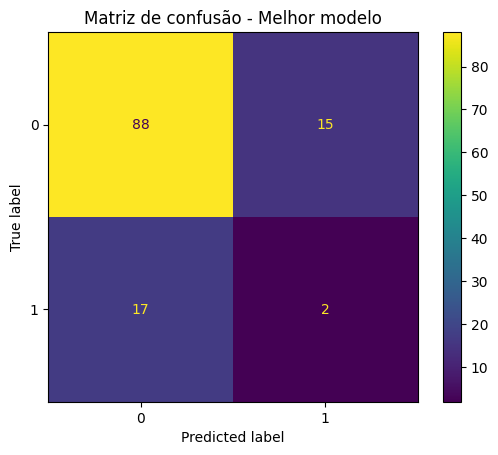

CPU times: user 338 ms, sys: 811 µs, total: 339 ms
Wall time: 314 ms


In [88]:
%%time
if 'search' in globals() and hasattr(search, "best_estimator_"):
    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_train = best_model.predict(X_train)

else:
    raise RuntimeError("Objeto 'search' com best_estimator_ não encontrado.")
print("Dados de TESTE")
print(classification_report(y_test, y_pred))
print("Dados de TREINAMENTO")
print(classification_report(y_train, y_pred_train))

try:
    ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
    plt.title("Matriz de confusão - Melhor modelo")
    plt.show()
except Exception as e:
    print("Não foi possível plotar a matriz de confusão:", e)

### Observação sobre Overfitting no Melhor Modelo
O modelo XGBoost otimizado apresentou desempenho perfeito no conjunto de **treino** (100% de acurácia e F1 para ambas as classes), mas desempenho limitado no **teste**, especialmente na classe positiva (vencedores), com recall de apenas 0.11. Esse comportamento indica **overfitting**: o modelo memorizou os exemplos de treino e não conseguiu generalizar para novos dados.
### Próximos Passos
Para tentar reduzir o overfitting e melhorar a detecção da classe positiva, será realizada uma nova etapa de otimização de parâmetros. Para isso, é interessante:

- Permitir **um pouco mais de profundidade e folhas** para capturar padrões reais sem voltar a memorizar.

- **Evidência para cortes:** elevar min_child_weight, gamma e max_delta_step para só dividir quando houver ganho claro (tentativa de reduzir falsos positivos).

- **Regularizar pesos:** reg_alpha (L1) e reg_lambda (L2).

- **Aprendizado estável:** learning_rate baixo com n_estimators suficiente, priorizando passos pequenos e controlados.

- **Alinhar o critério de seleção:** trocar o scorer para priorizar o F1 da classe dos vencedores e ajustar scale_pos_weight para não marcar 1 com tanta facilidade.

O objetivo é que a árvore será equilibrada (nem rasa, nem profunda), com regras mais exigentes para prever “vencedor”, evitando gerar falsos positivos enquanto a prioridade é acertar a classe vencedora.

In [89]:
%%time
param_dist_2 = {
    "model__n_estimators": randint(800, 2000),
    "model__learning_rate": loguniform(5e-4, 3e-2),     # baixo
    "model__max_depth": randint(3, 6),
    "model__max_leaves": randint(16, 48),               # mais folhas
    "model__min_child_weight": randint(8, 20),          # nós precisam de mais exemplos
    "model__gamma": uniform(2.0, 3.0),
    "model__max_delta_step": randint(1, 5),
    "model__reg_alpha": loguniform(1e-3, 1.0),          # L1 moderada
    "model__reg_lambda": loguniform(1e1, 1.5e2),        # L2 moderada/forte
    "model__subsample": uniform(0.65, 0.25),
    "model__colsample_bytree": uniform(0.65, 0.25),
    "model__scale_pos_weight": uniform(spw*0.5, spw*0.5)
}

search_2 = RandomizedSearchCV(
    model,
    param_distributions=param_dist_2,
    n_iter=30,
    cv=cv,
    scoring=scorer,
    random_state=SEED,
    n_jobs=-1,
    verbose=1
)

search_2.fit(X_train, y_train)
best_model_2 = search_2.best_estimator_
print("Melhor score (CV):", search_2.best_score_)
print("Melhores parâmetros:", search_2.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Melhor score (CV): 0.8226522840692173
Melhores parâmetros: {'model__colsample_bytree': np.float64(0.7771426727911757), 'model__gamma': np.float64(4.7226994217782785), 'model__learning_rate': np.float64(0.0013875520816523175), 'model__max_delta_step': 1, 'model__max_depth': 5, 'model__max_leaves': 26, 'model__min_child_weight': 11, 'model__n_estimators': 1324, 'model__reg_alpha': np.float64(0.0017019223026554016), 'model__reg_lambda': np.float64(21.916648934711255), 'model__scale_pos_weight': np.float64(3.0840227693953755), 'model__subsample': np.float64(0.8824244130856433)}
CPU times: user 7.99 s, sys: 108 ms, total: 8.09 s
Wall time: 58.2 s


Dados de TESTE
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       103
           1       0.33      0.32      0.32        19

    accuracy                           0.80       122
   macro avg       0.60      0.60      0.60       122
weighted avg       0.79      0.80      0.79       122

Dados de TREINAMENTO
              precision    recall  f1-score   support

           0       0.91      0.92      0.92       409
           1       0.55      0.53      0.54        77

    accuracy                           0.86       486
   macro avg       0.73      0.73      0.73       486
weighted avg       0.86      0.86      0.86       486



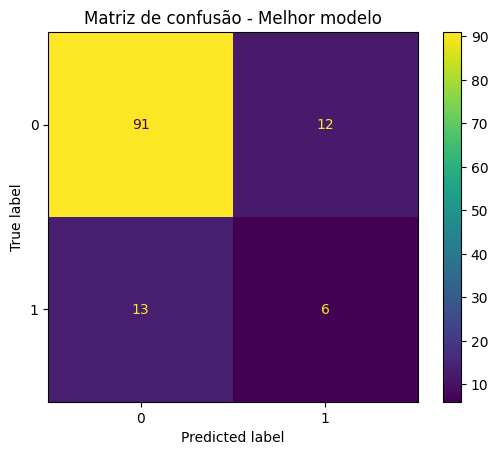

CPU times: user 480 ms, sys: 0 ns, total: 480 ms
Wall time: 475 ms


In [90]:
%%time
if 'search_2' in globals() and hasattr(search, "best_estimator_"):
    best_model_2 = search_2.best_estimator_
    y_pred = best_model_2.predict(X_test)
    y_pred_train = best_model_2.predict(X_train)

else:
    raise RuntimeError("Objeto 'search' com best_estimator_ não encontrado.")
print("Dados de TESTE")
print(classification_report(y_test, y_pred))
print("Dados de TREINAMENTO")
print(classification_report(y_train, y_pred_train))

try:
    ConfusionMatrixDisplay.from_estimator(best_model_2, X_test, y_test)
    plt.title("Matriz de confusão - Melhor modelo")
    plt.show()
except Exception as e:
    print("Não foi possível plotar a matriz de confusão:", e)

**Resultado:**

- **TESTE —** classe 1: precision=0.33, recall=0.32, f1=0.32; acurácia=0.80

- **TREINO —** classe 1: precision=0.55, recall=0.53, f1=0.54; acurácia=0.86

**Discussão:**
- o **recall** da classe vencedores **saltou de 0.11 → 0.32** no teste (de 2/19 para 6/19 acertos);
- a **acurácia** subiu de **0,74 → 0,80** no teste;
- o **macro-F1** subiu de **0,48 → 0,60** — sinal claro de maior equilíbrio entre as classes;
- o **overfitting** reduziu de extremo (treino 1,00) para moderado (**treino 0,86 vs teste 0,80; F1(1) 0,54 vs 0,32**) — ainda há gap, mas é bem menor!

**Verificando o desempenho do Baseline:**

TESTE do Modelo Baseline
              precision    recall  f1-score   support

           0      0.844     1.000     0.916       103
           1      0.000     0.000     0.000        19

    accuracy                          0.844       122
   macro avg      0.422     0.500     0.458       122
weighted avg      0.713     0.844     0.773       122



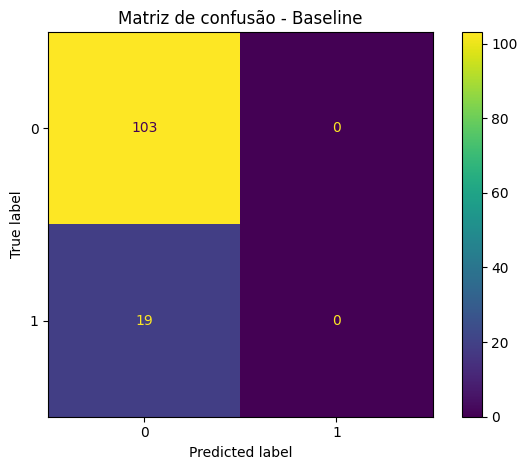

CPU times: user 439 ms, sys: 0 ns, total: 439 ms
Wall time: 467 ms


In [91]:
%%time
base = clone(baseline).fit(X_train, y_train)  # reutilizando o pipeline baseline
y_pred_base = base.predict(X_test)

print("TESTE do Modelo Baseline")
print(classification_report(y_test, y_pred_base, digits=3, zero_division=0))

ConfusionMatrixDisplay.from_estimator(base, X_test, y_test)
plt.title("Matriz de confusão - Baseline")
plt.tight_layout()
plt.show()

Como discutido, o **baseline** classificou praticamente tudo como “não vencedor” — algo visível na matriz de confusão — e exibiu **acurácia alta, porém inflada pelo desbalanceamento**. No teste, gerou **0 verdadeiros positivos e 19 falsos negativos**. Já o **XGBoost otimizado** recuperou parte dos vencedores (**6 verdadeiros positivos e 13 falsos negativos**), assumindo o **trade-off** de **produzir alguns falsos positivos (12)**. Por isso, a acurácia sozinha camufla o desempenho real: para o objetivo deste MVP — acertar os filmes vencedores — **o XGBoost otimizado é preferível**, pois entrega **ganho claro em recall e F1 da classe dos vencedores**.

### Testando *Ensemble*

Apesar do XGBoost já ser um ensemble homogêneo do tipo gradient boosting, vou testar um **ensemble heterogêneo do tipo voting**, combinando o **XGBoost otimizado** com a **Regressão Logística** balanceada escolhida anteriormente neste MVP. O objetivo é reduzir os falsos positivos sem reduzir as métricas da classe vencedora, especialmente recall(1) e F1(1). Assim, **escolherei o ensemble apenas se**, no teste, observar **menos falsos positivos e recall(1)/F1(1) ≥ os do XGBoost otimizado**. **Caso contrário, sigo com o XGBoost** como modelo final.

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ENSEMBLE (Voting)
              precision    recall  f1-score   support

           0      0.874     0.806     0.838       103
           1      0.259     0.368     0.304        19

    accuracy                          0.738       122
   macro avg      0.566     0.587     0.571       122
weighted avg      0.778     0.738     0.755       122



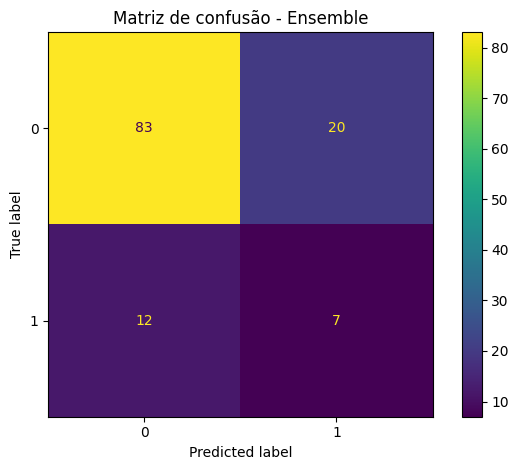

CPU times: user 2.77 s, sys: 38.9 ms, total: 2.8 s
Wall time: 2.45 s


In [92]:
%%time

# XGB já otimizado (pipeline)
xgb_pipe = clone(best_model_2)

# LogReg balanceada e normalizado
lr_pipe = Pipeline([
        ("pre", preprocess_COM_norm),
        ("model", LogisticRegression(max_iter=200, class_weight="balanced", random_state=SEED))
        ]) #normalizado e sem feature selection

voter = VotingClassifier(
    estimators=[("xgb", xgb_pipe), ("lr", lr_pipe)],
    voting="soft",
    weights=[2, 1]  # teste [1,1] também
)
voter.fit(X_train, y_train)
print("ENSEMBLE (Voting)")
print(classification_report(y_test, voter.predict(X_test), digits=3, zero_division=0))
ConfusionMatrixDisplay.from_estimator(voter, X_test, y_test)
plt.title("Matriz de confusão - Ensemble")
plt.tight_layout()
plt.show()

O **ensemble (Voting)** acertou 7 de 19 vencedores (**recall(1)=0,368**), enquanto o **XGBoost** otimizado acertou 6 de 19 (**recall(1)=0,32**). Porém, quando o Voting diz que um filme é vencedor, ele acerta menos: **precision(1)=0,259 no Voting vs 0,33 no XGBoost**, e o **F1(1) também cai (0,304 no Voting vs 0,32 no XGBoost)**.

Pelas matrizes de confusão:

Voting: 7 VP, 12 FN, 20 FP, 83 VN → recall(0)=0,806.

XGBoost otimizado: 6 VP, 13 FN, 12 FP, 91 VN → recall(0)=0,88.

Ou seja, **o Voting trocou +1 verdadeiro positivo por +8 falsos positivos**. Como o objetivo é encontrar um **modelo que tenha um desempenho decente na identificação da classe dos vencedores, o XGBoost otimizado continua sendo a melhor opção de modelo deste MVP**.


## 9. Conclusões e próximos passos

**Conclusões**  
- O problema de previsão dos vencedores do Oscar foi tratado como uma **classificação** em dados tabulares, com forte desbalanceamento entre indicados (classe majoritária) e vencedores (classe minoritária).  
- O **Dummy Classifier** serviu como baseline, confirmando que qualquer modelo útil precisaria superar o simples acerto da classe majoritária.  
- Entre os modelos testados, o **XGBoost** apresentou desempenho mais consistente que a Regressão Logística, especialmente no equilíbrio entre *recall* e *precision*.  
- O **Voting Ensemble** foi avaliado, mas não trouxe ganhos em relação ao XGBoost com os hiperparâmetros otimizado, reforçando a escolha deste como modelo final.  
- O ajuste de hiperparâmetros via *RandomizedSearchCV* melhorou o desempenho do XGBoost, mas aumentou significativamente o tempo de treinamento.  
- O trabalho reforçou a importância de métricas como *recall* e *F1-score* para a classe de vencedores, uma vez que a simples acurácia é enganosa no contexto de classes desbalanceadas.  

**Trade-offs observados**  
- O aumento do *recall* veio em detrimento da *precision*, ou seja, ao identificar mais vencedores, o modelo também trouxe mais falsos positivos.  
- O uso de ensemble ampliou a cobertura, mas reduziu a confiança nas previsões (queda na *precision* e no *F1*).  

**Próximos passos**  
- **Dados**: incorporar mais atributos dos filmes para enriquecer a base, considerar prever vencedores de alguma categoria do Oscar, e não apenas da categoria *Best Picture*.  
- **Modelos**: testar métodos mais avançados de balanceamento de classes (SMOTE, class weights ajustados) e explorar modelos de Deep Learning em dados textuais (sinopses, resenhas).  
- **Tuning**: experimentar *Bayesian Optimization* para otimização mais eficiente dos hiperparâmetros.  



## ✅ Checklist do MVP
- [✅] **Problema definido** e contexto de negócio:

  Preenchi a seção de Escopo, objetivo e definição do problema (Oscar, classificação binária, dados tabulares, valor cultural e prático).
- [✅] **Carga e preparação** dos dados (sem vazamento de dados)

  Carreguei os datasets usando uma URL para os arquivos no meu projeto do Github e limpei os datasets para conseguir realizar o merge entre os dados (corrigi títulos, tratamos duplicados e usei uma regra de tolerância para o ano do filme).
- [✅] **Divisão** em treino/validação/teste (ou validação cruzada apropriada)

  Separei o dataset de forma estratificada (84% não vencedores, 16% vencedores), usando train/test split e também aplicando StratifiedKFold para validação cruzada.

- [✅] **Tratamento**: limpeza, transformação e **engenharia de atributos**

  Realizei a correção de tipos (numéricos em object → float), codifiquei variáveis categóricas, normalizei variáveis numéricas, realizei feature selection das top 15 variáveis, e criei colunas para indicar a presença de nulos em várias colunas.


- [✅] **Modelagem**: comparar abordagens/modelos (com **baseline**)

  Optei por utilizar um Dummy Classifier como baseline e comparei Regressão Logística e XGBoost, ambos com e sem normalaização e feature selection. Por fim, testei um ensemble heterogêneo do tipo voting.
- [✅] **Otimização de hiperparâmetros**

  Rodei o RandomizedSearchCV com XGBoost.
- [✅] **Avaliação** com **métricas adequadas** e discussão de limitações

  Avaliei recall, precision e F1 considerando a classe dos vencedores. Dentre as discussões, destaquei a limitação/trade-off por ter dados desbalanceados, optando por um modelo que gera falsos positivos porém teve um equilíbrio entre as predições de vencedores e indicados.

- [✅] **Boas práticas**: seeds fixas, tempo de treino, recursos computacionais, documentação

  Fixei random_state=SEED, criei e utilizei pipelines reproduzíveis, documentei meu raciocínio e conclusões em células de texto, e utilizei o comando %%time nas células de treinamento e prediçãodos modelos, de forma a registrar o tempo de execução. Por fim, relacionado aos meus recursos computacionais, registrei no início do notebook qual é o meu CPU, quantos núcleos ele tem e a memória RAM total.

- [✅] **Pipelines reprodutíveis** (sempre que possível)

  Criei pipelines para pré-processamento + modelos, com visões diferentes considerando a utilização ou não da normalização e do feature selection.